<a href="https://colab.research.google.com/github/BeniIfland/BeniIfland/blob/main/code/chats/openAI/GeNet_notebooks/New_Results_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print(IN_COLAB)

True


In [2]:
if IN_COLAB:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/AUTONET/

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/19DFlX60iwVFe7elp0nLfnc7p_PWvTRYg/AUTONET


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import levene
from scipy.stats import kruskal
from scipy.stats import friedmanchisquare
from scipy.stats import ttest_ind
from statsmodels.stats.oneway import anova_oneway
from itertools import combinations
from scipy.stats import entropy
from scipy.stats import pearsonr, spearmanr

##Research Questions 1
###To what extent does GPT-4 Vision understand network topology images?

In [4]:
raw_vision_scores = pd.read_csv('./Vision_Experiment_Results/phase1_result_parsed_to_json/phase1_results_first_three_runs.csv')
raw_vision_scores

,Run1_Metric_score,Scenario,Platform,Diagram_Type,Temp,Run2_Metric_Score,Run3_Metric Score,Average TIUS
0,0.669900,Adding_Communication_Servers,GNS3,Messy_Layout,0.1,0.797436,0.797436,0.754924
1,0.834936,Adding_Communication_Servers,GNS3,Messy_Layout,1.0,0.830769,0.797436,0.821047
2,0.785000,Adding_DMZ,GNS3,Messy_Layout,0.1,0.778452,0.811316,0.791589
3,0.765682,Adding_DMZ,GNS3,Messy_Layout,1.0,0.823816,0.808684,0.799394
4,0.709405,Adding_DRA,GNS3,Messy_Layout,0.1,0.739500,0.726071,0.724992
...,...,...,...,...,...,...,...,...
175,0.913636,Transparent_IOS_Firewall,PowerPoint,Normal,1.0,0.856818,0.900000,0.890152
176,0.926447,Basic_Zone_Based_Firewall,PowerPoint,Normal,0.1,0.952763,0.963289,0.947500
177,0.926447,Basic_Zone_Based_Firewall,PowerPoint,Normal,1.0,0.926447,0.926447,0.926447
178,0.903509,IP_Traffic_Export,PowerPoint,Normal,0.1,0.864167,0.877193,0.881623


In [5]:
vision_scores = raw_vision_scores[['Scenario','Temp','Platform','Diagram_Type','Average TIUS']]
vision_scores.rename(columns={'Average TIUS':'TIUS'},inplace=True)
vision_scores['Scenario'] = vision_scores['Scenario'].str.replace('_', ' ')
vision_scores['Diagram_Type'] = vision_scores['Diagram_Type'].replace('Messy_Layout', 'Messy Layout')
vision_scores['Platform'] = vision_scores['Platform'].replace('Paper_Sketches', 'Paper Sketches')
vision_scores['Diagram_Type'] = vision_scores['Diagram_Type'].replace('No_Labels_On_Edges', 'No Labels on Edges')
configuration_scenarios = ['Role Based CLI Access', 'Time Based Access List', 'IP Traffic Export','Transparent IOS Firewall','Basic Zone Based Firewall'] # Replace with your actual scenario names
topology_scenarios = ['Internet Connectivity', 'Adding DMZ', 'Adding DRA', 'Adding Local PCs', 'Adding Communication Servers'] # Replace with your actual scenario names
vision_scores['Type'] = 'Unknown'
# Assign 'Configuration' to the corresponding scenarios
vision_scores.loc[vision_scores['Scenario'].isin(configuration_scenarios), 'Type'] = 'Configuration'
# Assign 'Topology' to the corresponding scenarios
vision_scores.loc[vision_scores['Scenario'].isin(topology_scenarios), 'Type'] = 'Topology'
vision_scores

<ipython-input-5-490d73038efb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vision_scores.rename(columns={'Average TIUS':'TIUS'},inplace=True)
<ipython-input-5-490d73038efb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vision_scores['Scenario'] = vision_scores['Scenario'].str.replace('_', ' ')
<ipython-input-5-490d73038efb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,Scenario,Temp,Platform,Diagram_Type,TIUS,Type
0,Adding Communication Servers,0.1,GNS3,Messy Layout,0.754924,Topology
1,Adding Communication Servers,1.0,GNS3,Messy Layout,0.821047,Topology
2,Adding DMZ,0.1,GNS3,Messy Layout,0.791589,Topology
3,Adding DMZ,1.0,GNS3,Messy Layout,0.799394,Topology
4,Adding DRA,0.1,GNS3,Messy Layout,0.724992,Topology
...,...,...,...,...,...,...
175,Transparent IOS Firewall,1.0,PowerPoint,Normal,0.890152,Configuration
176,Basic Zone Based Firewall,0.1,PowerPoint,Normal,0.947500,Configuration
177,Basic Zone Based Firewall,1.0,PowerPoint,Normal,0.926447,Configuration
178,IP Traffic Export,0.1,PowerPoint,Normal,0.881623,Configuration


## Phase 4 Data Preprocess

In [6]:
raw_ii_scores = pd.read_csv('/gdrive/MyDrive/AUTONET/Vision_Experiment_Results/Corrected_verifier_LLM_Evaluator_with_descriptions/Weighted_Score_on_Mean_Grade.csv')
ii_scores = raw_ii_scores[['Scenario','Phase1_Temp','Phase4_Temp','Platform','Diagram_Type','Mean_grade','weighted_score']]
ii_scores.rename(columns={'Mean_grade':'Score'},inplace=True)
ii_scores['Scenario'] = ii_scores['Scenario'].str.replace('_', ' ')
ii_scores['Diagram_Type'] = ii_scores['Diagram_Type'].replace('Messy_Layout', 'Messy Layout')
ii_scores['Platform'] = ii_scores['Platform'].replace('Paper_Sketches', 'Paper Sketches')
ii_scores['Diagram_Type'] = ii_scores['Diagram_Type'].replace('No_Labels_On_Edges', 'No Labels on Edges')
configuration_scenarios = ['Role Based CLI Access', 'Time Based Access List', 'IP Traffic Export','Transparent IOS Firewall','Basic Zone Based Firewall'] # Replace with your actual scenario names
topology_scenarios = ['Internet Connectivity', 'Adding DMZ', 'Adding DRA', 'Adding Local PCs', 'Adding Communication Servers'] # Replace with your actual scenario names
ii_scores['Type'] = 'Unknown'
# Assign 'Configuration' to the corresponding scenarios
ii_scores.loc[ii_scores['Scenario'].isin(configuration_scenarios), 'Type'] = 'Configuration'
# Assign 'Topology' to the corresponding scenarios
ii_scores.loc[ii_scores['Scenario'].isin(topology_scenarios), 'Type'] = 'Topology'

#Join phase 1 and phase 4 results
vision_scores.rename(columns={'Temp':'Phase1_Temp'},inplace=True)
data_four_one = ii_scores.merge(vision_scores, on=['Scenario','Phase1_Temp','Platform','Diagram_Type','Type'])
data_four_one['Temp'] = list(zip(data_four_one['Phase1_Temp'], data_four_one['Phase4_Temp']))
data_four_one = data_four_one[['Scenario','Temp','Platform','Diagram_Type','Type','Score', 'TIUS','weighted_score']]
data_four_one['Temp'] = data_four_one['Temp'].apply(str)
data_four_one

<ipython-input-6-b95e50b04050>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ii_scores.rename(columns={'Mean_grade':'Score'},inplace=True)
<ipython-input-6-b95e50b04050>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ii_scores['Scenario'] = ii_scores['Scenario'].str.replace('_', ' ')
<ipython-input-6-b95e50b04050>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

,Scenario,Temp,Platform,Diagram_Type,Type,Score,TIUS,weighted_score
0,Adding Communication Servers,"(0.1, 0.1)",GNS3,Messy Layout,Topology,80.000000,0.754924,47.368421
1,Adding Communication Servers,"(0.1, 1.0)",GNS3,Messy Layout,Topology,76.666667,0.754924,38.596491
2,Adding Communication Servers,"(1.0, 0.1)",GNS3,Messy Layout,Topology,70.000000,0.821047,21.052632
3,Adding Communication Servers,"(1.0, 1.0)",GNS3,Messy Layout,Topology,70.000000,0.821047,21.052632
4,Adding DMZ,"(0.1, 0.1)",GNS3,Messy Layout,Topology,45.000000,0.791589,45.000000
...,...,...,...,...,...,...,...,...
355,Basic Zone Based Firewall,"(1.0, 1.0)",PowerPoint,Normal,Configuration,92.333333,0.926447,76.767677
356,IP Traffic Export,"(0.1, 0.1)",PowerPoint,Normal,Configuration,90.000000,0.881623,80.000000
357,IP Traffic Export,"(0.1, 1.0)",PowerPoint,Normal,Configuration,98.333333,0.881623,96.666667
358,IP Traffic Export,"(1.0, 0.1)",PowerPoint,Normal,Configuration,100.000000,0.919123,100.000000


In [7]:
#(0.1,0.1) - i
#(0.1,1.0) - ii
#(1.0,0.1) - iii
#(1.0,1.0) - iv
i = data_four_one[data_four_one['Temp'] == '(0.1, 0.1)']
ii = data_four_one[data_four_one['Temp'] == '(0.1, 1.0)']
iii = data_four_one[data_four_one['Temp'] == '(1.0, 0.1)']
iv = data_four_one[data_four_one['Temp'] == '(1.0, 1.0)']
df_topo = data_four_one[data_four_one['Type'] == 'Topology']
df_config = data_four_one[data_four_one['Type'] == 'Configuration']
target_temps = ['(0.1, 0.1)', '(1.0, 1.0)']

# Filter the DataFrame
aligned_temps = data_four_one[data_four_one['Temp'].isin(target_temps)]
plt.rcParams['font.size'] = 20

##Original TIUS

In [22]:
# df_topo = iv[iv['Type'] == 'Topology']
# df_config = iv[iv['Type'] == 'Configuration']
df_topo = iv_all[iv_all['Type'] == 'Topology']
df_config = iv_all[iv_all['Type'] == 'Configuration']

<ipython-input-11-a495f94f50a8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='TIUS', data=iv_all, palette='muted')


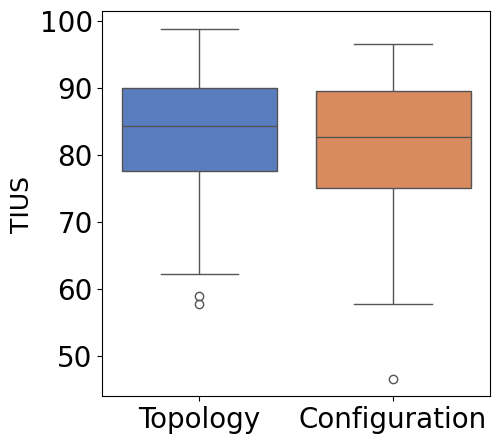

In [11]:
iv_all['TIUS'] = iv_all['TIUS']*100
plt.figure(figsize=(5, 5))
# plt.rcParams.update({'font.size': 14})
sns.boxplot(x='Type', y='TIUS', data=iv_all, palette='muted')
# sns.boxplot(x='Type', y='Score', data=data, palette='muted')
# plt.title('Topology Extractor Module Score by Test Case Type')
plt.xlabel('')
plt.ylabel('TIUS',fontsize=18)
plt.show()

In [26]:
levene_stat, levene_p = levene(df_topo['TIUS'], df_config['TIUS'])
print(f"Levene's test statistic: {levene_stat:.3f}")
print(f"Levene's test p-value: {levene_p:.3f}")

welch_stat, welch_p = ttest_ind(df_topo['TIUS'], df_config['TIUS'], equal_var=False) # Welch's t-test assumes unequal variances
print(f"Welch's t-test statistic: {welch_stat:.3f}")
print(f"Welch's t-test p-value: {welch_p:.3f}")

Levene's test statistic: 0.001
Levene's test p-value: 0.982
Welch's t-test statistic: 0.486
Welch's t-test p-value: 0.628


<ipython-input-16-1715797fcd6d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Phase1_Temp':'Temp'},inplace=True)
/usr/local/lib/python3.10/dist-packages/numpy/lib/polynomial.py:668: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


LinAlgError: SVD did not converge in Linear Least Squares

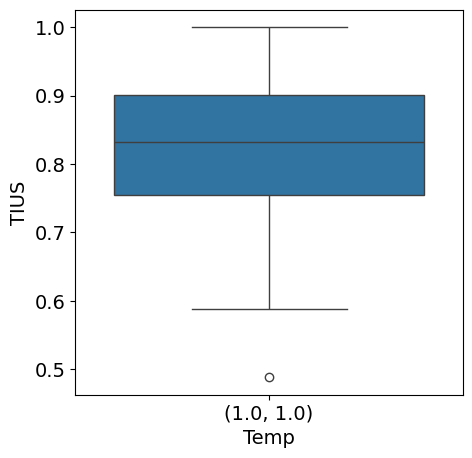

In [16]:
def plot_temps(df):
  df.rename(columns={'Phase1_Temp':'Temp'},inplace=True)
  plt.figure(figsize=(5, 5))
  sns.boxplot(x='Temp', y='TIUS', data=df)

  means = df.groupby('Temp')['TIUS'].mean()
  x = range(0, len(means))

  # Linear interpolation for trend line
  slope, intercept = np.polyfit(x, means, 1)
  plt.plot(x, slope * x + intercept, color='r', linestyle='-')

  # plt.title("Topology Understanding Score vs Temperature Values")
  plt.xlabel('Temperature')
  plt.ylabel('TIUS')
  plt.show()
plot_temps(df_config)

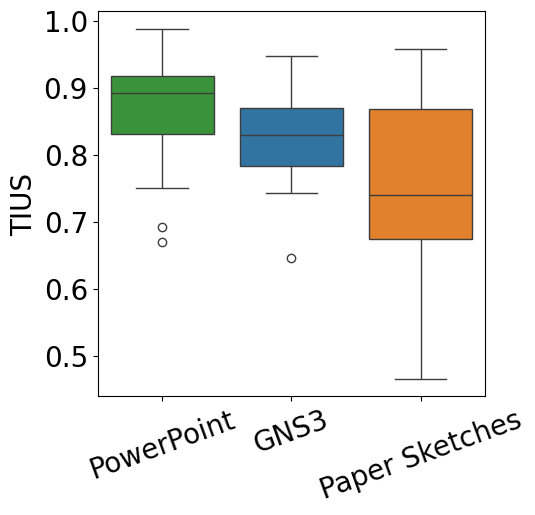

In [27]:
desired_order = ['PowerPoint','GNS3', 'Paper Sketches']  # Replace with your specific order

# Plot the boxplot
plt.figure(figsize=(5, 5))
sns.boxplot(x='Platform', y='TIUS', data=iv_all, hue='Platform', order=desired_order)

# Customize labels and appearance
plt.xlabel('')
plt.ylabel('TIUS')
plt.xticks(rotation=20)
plt.show()

In [34]:

messy_layout_paper_sketches = iv[
    (iv['Diagram_Type'] == 'Messy Layout') &
    (iv['Platform'] == 'Paper Sketches')
]

# Display the filtered DataFrame
messy_layout_paper_sketches['TIUS'].describe()

,TIUS
count,10.000000
mean,0.730754
std,0.097487
min,0.587737
25%,0.685959
50%,0.709558
75%,0.795728
max,0.917675


In [27]:
iv.groupby('Platform')['TIUS'].describe()

,count,mean,std,min,25%,50%,75%,max
Platform,,,,,,,,
GNS3,30.0,0.834445,0.068979,0.644167,0.794365,0.82821,0.883112,0.966667
Paper Sketches,30.0,0.754883,0.117509,0.488276,0.672750,0.74375,0.851359,0.944823
PowerPoint,30.0,0.872891,0.083056,0.644192,0.818920,0.89875,0.925570,1.000000


In [28]:
iv.groupby('Diagram_Type')['TIUS'].describe()

,count,mean,std,min,25%,50%,75%,max
Diagram_Type,,,,,,,,
Messy Layout,30.0,0.794211,0.102853,0.587737,0.728063,0.797045,0.873519,1.000000
No Labels on Edges,30.0,0.803386,0.087665,0.590000,0.770621,0.822816,0.863728,0.900000
Normal,30.0,0.864622,0.107998,0.488276,0.828125,0.903640,0.930286,0.975926


In [28]:
from scipy.stats import ttest_ind

# Group data by platform
platforms = iv_all['Platform'].unique()
platform_groups = {platform: iv_all[iv_all['Platform'] == platform]['TIUS'] for platform in platforms}

# Perform pairwise t-tests
for platform1, platform2 in combinations(platforms, 2):
    t_stat, p_value = ttest_ind(platform_groups[platform1], platform_groups[platform2])
    print(f"T-test between {platform1} and {platform2}:")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value: {p_value:.3f}")

T-test between GNS3 and Paper Sketches:
  t-statistic: 2.944
  p-value: 0.005
T-test between GNS3 and PowerPoint:
  t-statistic: -2.426
  p-value: 0.018
T-test between Paper Sketches and PowerPoint:
  t-statistic: -4.534
  p-value: 0.000


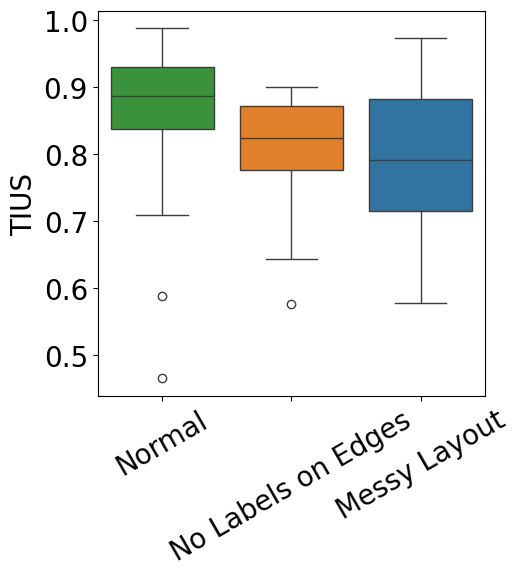

In [29]:
desired_order = ['Normal','No Labels on Edges', 'Messy Layout']  # Replace with your specific order
plt.figure(figsize=(5, 5))
sns.boxplot(x='Diagram_Type', y='TIUS', data=iv_all, hue='Diagram_Type',order = desired_order)
# means = vision_scores.groupby('Diagram_Type')['TIUS'].mean()
# plt.title("Topology Understanding Score vs Temperature Values")
plt.xlabel('')
plt.ylabel('TIUS')
plt.xticks(rotation=30)
plt.show()

In [30]:

# Group data by platform
types = iv_all['Diagram_Type'].unique()
platform_groups = {platform: iv_all[iv_all['Diagram_Type'] == platform]['TIUS'] for platform in types}

# Perform pairwise t-tests
for platform1, platform2 in combinations(types, 2):
    t_stat, p_value = ttest_ind(platform_groups[platform1], platform_groups[platform2])
    print(f"T-test between {platform1} and {platform2}:")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value: {p_value:.3f}")

T-test between Messy Layout and No Labels on Edges:
  t-statistic: -0.478
  p-value: 0.634
T-test between Messy Layout and Normal:
  t-statistic: -2.409
  p-value: 0.019
T-test between No Labels on Edges and Normal:
  t-statistic: -2.119
  p-value: 0.038


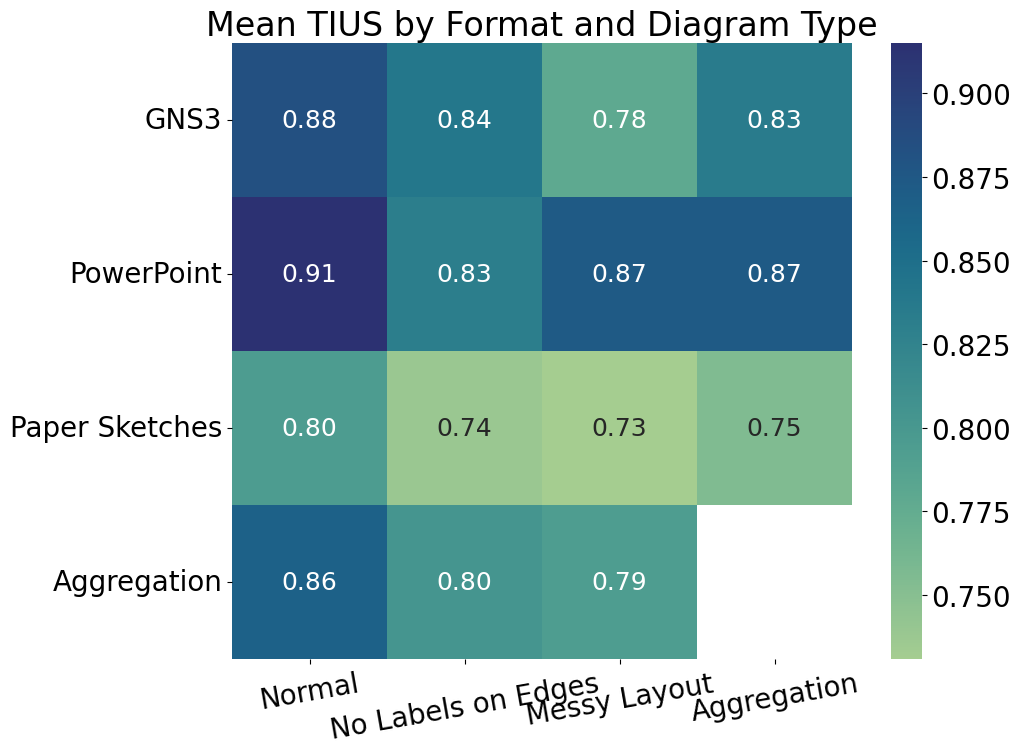

In [41]:
def plot_vision_heatmap(df):
  means = df.groupby(['Platform', 'Diagram_Type'])['TIUS'].mean().unstack()
  row_order = ['GNS3','PowerPoint','Paper Sketches','Aggregation']  # Update with your actual row names
  column_order = ['Normal', 'No Labels on Edges','Messy Layout', 'Aggregation']  # Update with your actual column names
  means['Aggregation'] = df.groupby('Platform')['TIUS'].mean()
  new_row = df.groupby('Diagram_Type')['TIUS'].mean()
  means = pd.concat([means, pd.DataFrame([new_row], index=['Aggregation'])])
  means = means.reindex(index=row_order, columns=column_order)
  # sorted_means.rename(columns={'No_Labels_On_Edges':'No Labels on Edges','Messy_Layout':'Messy Layout'},inplace=True)
  # sorted_means.index = sorted_means.index.where(sorted_means.index != 'Paper_Sketches', 'Paper Sketches')
  plt.figure(figsize=(10, 8))
  sns.heatmap(means, annot=True, cmap='crest', fmt=".2f",annot_kws={"size": 18})
  plt.title('Mean TIUS by Format and Diagram Type')
  plt.xlabel('')
  plt.ylabel('')
  plt.xticks(rotation=10)
  plt.show()
plot_vision_heatmap(iv)

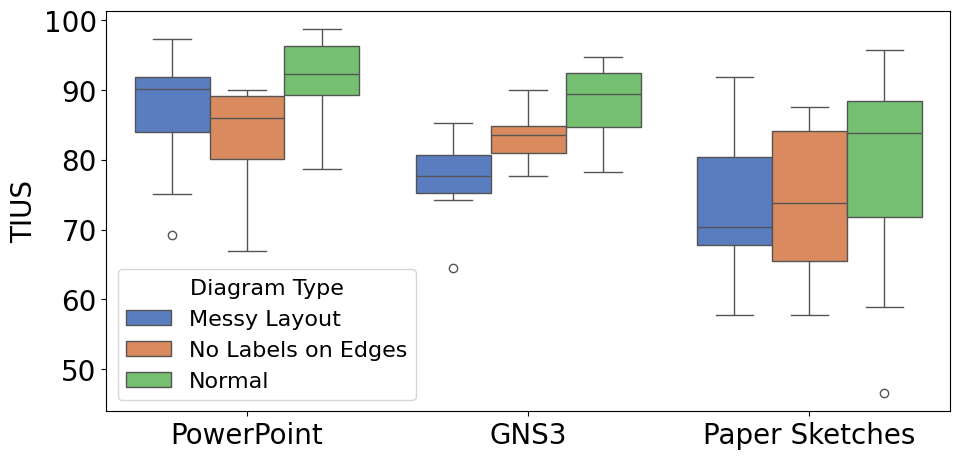

In [12]:
# Group the data by 'Platform' and 'Diagram_Type' and calculate mean scores.
desired_order = ['PowerPoint','GNS3', 'Paper Sketches']  # Replace with your specific order

def plot_vision_boxplots(df):
  means = df.groupby(['Platform', 'Diagram_Type'])['TIUS'].mean().reset_index()

  # Create a boxplot.
  plt.figure(figsize=(10, 5))
  sns.boxplot(
      data=df,
      x='Platform',
      y='TIUS',
      hue='Diagram_Type',
      palette='muted',
      order = desired_order
  )

  # Customize plot aesthetics.
  # plt.title('Distribution of TIUS by Diagram Type and Format')#, fontsize=16
  plt.xlabel('')
  plt.ylabel('TIUS') #, fontsize=14
  # plt.xticks(rotation=15) #, fontsize=12
  # plt.yticks(fontsize=12)
  plt.legend(title='Diagram Type',  loc='lower left', title_fontsize=16, fontsize=16)
  plt.xticks(rotation=0)
  # Show the plot.
  plt.tight_layout()
  plt.show()
plot_vision_boxplots(iv_all)

##Fixed TIUS

<ipython-input-40-3841408ef4fd>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Fixed TIUS', data=vision_scores, palette='muted')


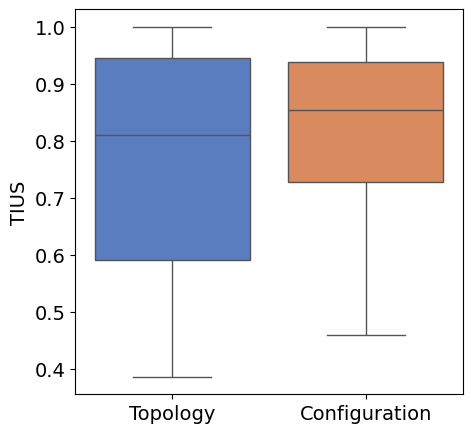

In [40]:
plt.figure(figsize=(5, 5))
plt.rcParams.update({'font.size': 14})
sns.boxplot(x='Type', y='Fixed TIUS', data=vision_scores, palette='muted')
# sns.boxplot(x='Type', y='Score', data=data, palette='muted')
# plt.title('Topology Extractor Module Score by Test Case Type')
plt.xlabel('')
plt.ylabel('TIUS',fontsize=14)
plt.show()

<ipython-input-59-7b3bf15b75e6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Fixed TIUS', data=iv, palette='muted')


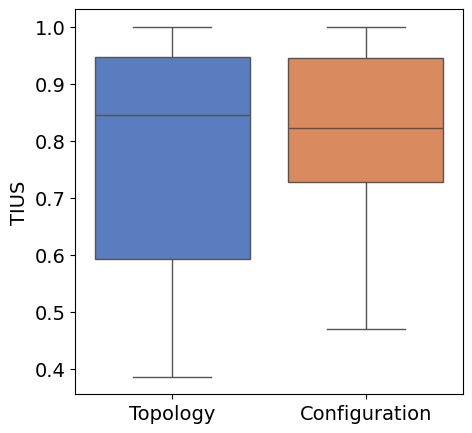

In [59]:
plt.figure(figsize=(5, 5))
plt.rcParams.update({'font.size': 14})
sns.boxplot(x='Type', y='Fixed TIUS', data=iv, palette='muted')
# sns.boxplot(x='Type', y='Score', data=data, palette='muted')
# plt.title('Topology Extractor Module Score by Test Case Type')
plt.xlabel('')
plt.ylabel('TIUS',fontsize=14)
plt.show()

Levene's variance equality test

In [138]:
groups = vision_scores.groupby('Type')['Fixed TIUS'].apply(list)

# Performing Levene's test
statistic, p_value = levene(*groups)

# Printing the results
print(f"Levene's variance equality test statistic: {statistic}")
print(f"Levene's test p-value: {p_value}")

# Determining significance and conclusion
alpha = 0.05  # Significance level
if p_value < alpha:
    print(f"The test is significant (p < {alpha}). Variances are not equal among the groups.")
else:
    print(f"The test is not significant (p >= {alpha}). Variances are equal among the groups.")


Levene's variance equality test statistic: 6.011011273618514
Levene's test p-value: 0.015182135380737906
The test is significant (p < 0.05). Variances are not equal among the groups.


In [142]:
groups = vision_scores.groupby('Type')['Fixed TIUS'].apply(list)

# Performing Welch's t-test
group1, group2 = groups.iloc[0], groups.iloc[1]  # Assuming two groups for the t-test
statistic, p_value = ttest_ind(group1, group2, equal_var=False)

# Printing the results
print(f"Welch's t-test statistic: {statistic}")
print(f"Welch's t-test p-value: {p_value}")

# Determining significance and conclusion
alpha = 0.05  # Significance level
if p_value < alpha:
    print(f"The test is significant (p < {alpha}). The means of the two groups are significantly different.")
else:
    print(f"The test is not significant (p >= {alpha}). The means of the two groups are not significantly different.")


Welch's t-test statistic: 1.5773310044654518
Welch's t-test p-value: 0.11658942657869031
The test is not significant (p >= 0.05). The means of the two groups are not significantly different.


In [60]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='Temp', y='TIUS', data=vision_scores)

means = vision_scores.groupby('Temp')['Fixed TIUS'].mean()
x = range(0, len(means))

# Linear interpolation for trend line
slope, intercept = np.polyfit(x, means, 1)
plt.plot(x, slope * x + intercept, color='r', linestyle='-')

# plt.title("Topology Understanding Score vs Temperature Values")
plt.xlabel('Temperature')
plt.ylabel('TIUS')
plt.show()

ValueError: Could not interpret value `Temp` for `x`. An entry with this name does not appear in `data`.

<Figure size 500x500 with 0 Axes>

In [144]:
groups = vision_scores.groupby('Phase1_Temp')['Fixed TIUS'].apply(list)

# Performing Levene's test
statistic, p_value = levene(*groups)

# Printing the results
print(f"Levene's variance equality test statistic: {statistic}")
print(f"Levene's test p-value: {p_value}")

# Determining significance and conclusion
alpha = 0.05  # Significance level
if p_value < alpha:
    print(f"The test is significant (p < {alpha}). Variances are not equal among the groups.")
else:
    print(f"The test is not significant (p >= {alpha}). Variances are equal among the groups.")


Levene's variance equality test statistic: 0.02104374791916689
Levene's test p-value: 0.8848239699320599
The test is not significant (p >= 0.05). Variances are equal among the groups.


In [145]:
groups = vision_scores.groupby('Phase1_Temp')['Fixed TIUS'].apply(list)

# Performing Welch's t-test
group1, group2 = groups.iloc[0], groups.iloc[1]  # Assuming two groups for the t-test
statistic, p_value = ttest_ind(group1, group2, equal_var=False)

# Printing the results
print(f"Welch's t-test statistic: {statistic}")
print(f"Welch's t-test p-value: {p_value}")

# Determining significance and conclusion
alpha = 0.05  # Significance level
if p_value < alpha:
    print(f"The test is significant (p < {alpha}). The means of the two groups are significantly different.")
else:
    print(f"The test is not significant (p >= {alpha}). The means of the two groups are not significantly different.")


Welch's t-test statistic: 0.062203683901379356
Welch's t-test p-value: 0.9504704224216292
The test is not significant (p >= 0.05). The means of the two groups are not significantly different.


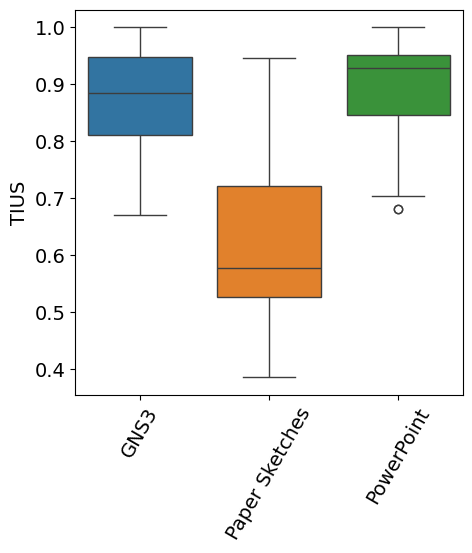

In [62]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='Platform', y='Fixed TIUS', data=vision_scores, hue='Platform')
means = vision_scores.groupby('Platform')['Fixed TIUS'].mean()
# plt.title("Topology Understanding Score vs Temperature Values")
plt.xlabel('')
plt.ylabel('TIUS')
plt.xticks(rotation=60)
plt.show()

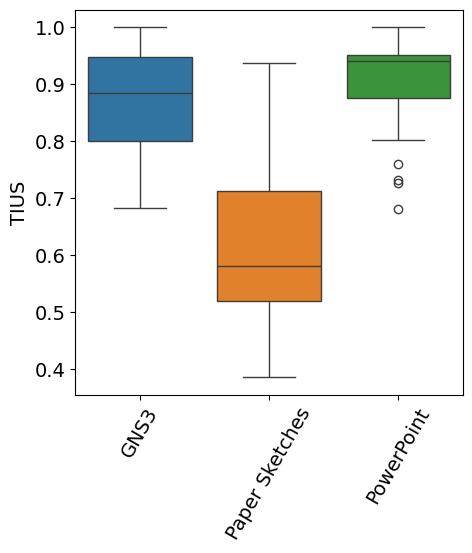

In [69]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='Platform', y='Fixed TIUS', data=iv, hue='Platform')
means = vision_scores.groupby('Platform')['Fixed TIUS'].mean()
# plt.title("Topology Understanding Score vs Temperature Values")
plt.xlabel('')
plt.ylabel('TIUS')
plt.xticks(rotation=60)
plt.show()

In [168]:
# Grouping the data
groups = vision_scores.groupby('Diagram_Type')['Fixed TIUS'].apply(list)

# Performing pairwise Levene's tests for variance equality
print("Performing pairwise Levene's tests for variance equality:")

# Initialize a list to store results
pairwise_results = []
alpha = 0.05  # Significance level

for (group1_name, group1_data), (group2_name, group2_data) in combinations(groups.items(), 2):
    # Levene's test for equality of variances
    stat, p = levene(group1_data, group2_data)

    result = {
        'Group 1': group1_name,
        'Group 2': group2_name,
        'Statistic': stat,
        'p-value': p,
        'Conclusion': 'Significant' if p < alpha else 'Not Significant'
    }
    pairwise_results.append(result)

# Convert results into a DataFrame for better visualization
pairwise_results_df = pd.DataFrame(pairwise_results)
print(pairwise_results_df)


Performing pairwise Levene's tests for variance equality:
              Group 1             Group 2  Statistic   p-value  \
0        Messy Layout  No Labels on Edges   3.180339  0.077100   
1        Messy Layout              Normal   0.509200  0.476894   
2  No Labels on Edges              Normal   1.017502  0.315176   

        Conclusion  
0  Not Significant  
1  Not Significant  
2  Not Significant  


In [167]:
# Grouping the data
groups = vision_scores.groupby('Diagram_Type')['Fixed TIUS'].apply(list)

# Performing pairwise Welch's t-tests
print("Performing pairwise Welch's t-tests:")

# Initialize a list to store results
pairwise_results = []
alpha = 0.05  # Significance level

for (group1_name, group1_data), (group2_name, group2_data) in combinations(groups.items(), 2):
    # Welch's t-test with unequal variances
    stat, p = ttest_ind(group1_data, group2_data, equal_var=True)

    result = {
        'Group 1': group1_name,
        'Group 2': group2_name,
        'Statistic': stat,
        'p-value': p,
        'Conclusion': 'Significant' if p < alpha else 'Not Significant'
    }
    pairwise_results.append(result)

# Convert results into a DataFrame for better visualization
pairwise_results_df = pd.DataFrame(pairwise_results)
print(pairwise_results_df)


Performing pairwise Welch's t-tests:
              Group 1             Group 2  Statistic   p-value  \
0        Messy Layout  No Labels on Edges  -1.016865  0.311298   
1        Messy Layout              Normal  -1.418922  0.158558   
2  No Labels on Edges              Normal  -0.310509  0.756721   

        Conclusion  
0  Not Significant  
1  Not Significant  
2  Not Significant  


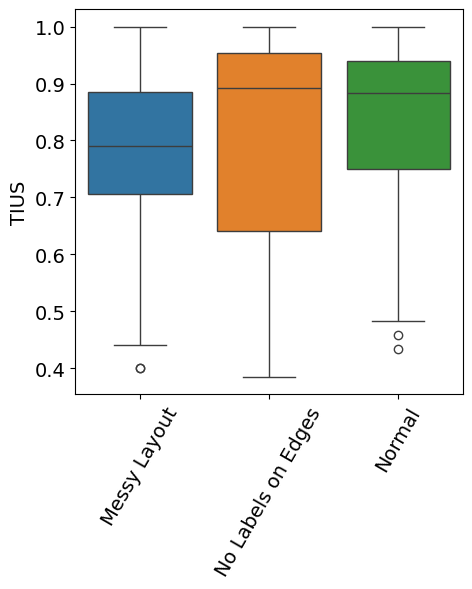

In [70]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='Diagram_Type', y='Fixed TIUS', data=vision_scores, hue='Diagram_Type')
means = vision_scores.groupby('Diagram_Type')['Fixed TIUS'].mean()
# plt.title("Topology Understanding Score vs Temperature Values")
plt.xlabel('')
plt.ylabel('TIUS')
plt.xticks(rotation=60)
plt.show()

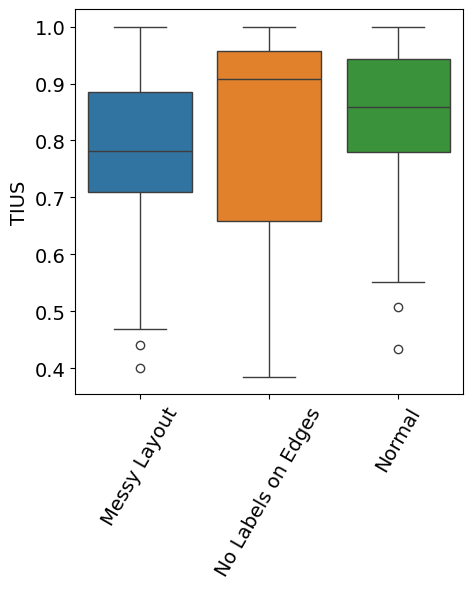

In [74]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='Diagram_Type', y='Fixed TIUS', data=iv, hue='Diagram_Type')
means = vision_scores.groupby('Diagram_Type')['Fixed TIUS'].mean()
# plt.title("Topology Understanding Score vs Temperature Values")
plt.xlabel('')
plt.ylabel('TIUS')
plt.xticks(rotation=60)
plt.show()

In [169]:
# Grouping the data
groups = vision_scores.groupby('Platform')['Fixed TIUS'].apply(list)

# Performing pairwise Levene's tests for variance equality
print("Performing pairwise Levene's tests for variance equality:")

# Initialize a list to store results
pairwise_results = []
alpha = 0.05  # Significance level

for (group1_name, group1_data), (group2_name, group2_data) in combinations(groups.items(), 2):
    # Levene's test for equality of variances
    stat, p = levene(group1_data, group2_data)

    result = {
        'Group 1': group1_name,
        'Group 2': group2_name,
        'Statistic': stat,
        'p-value': p,
        'Conclusion': 'Significant' if p < alpha else 'Not Significant'
    }
    pairwise_results.append(result)

# Convert results into a DataFrame for better visualization
pairwise_results_df = pd.DataFrame(pairwise_results)
print(pairwise_results_df)

Performing pairwise Levene's tests for variance equality:
          Group 1         Group 2  Statistic   p-value       Conclusion
0            GNS3  Paper Sketches   8.057216  0.005338      Significant
1            GNS3      PowerPoint   0.223001  0.637635  Not Significant
2  Paper Sketches      PowerPoint   8.937230  0.003401      Significant


In [170]:
# Grouping the data
groups = vision_scores.groupby('Platform')['Fixed TIUS'].apply(list)

# Performing pairwise Welch's t-tests
print("Performing pairwise Welch's t-tests:")

# Initialize a list to store results
pairwise_results = []
alpha = 0.05  # Significance level

for (group1_name, group1_data), (group2_name, group2_data) in combinations(groups.items(), 2):
    # Welch's t-test with unequal variances
    stat, p = ttest_ind(group1_data, group2_data, equal_var=True)

    result = {
        'Group 1': group1_name,
        'Group 2': group2_name,
        'Statistic': stat,
        'p-value': p,
        'Conclusion': 'Significant' if p < alpha else 'Not Significant'
    }
    pairwise_results.append(result)

# Convert results into a DataFrame for better visualization
pairwise_results_df = pd.DataFrame(pairwise_results)
print(pairwise_results_df)


Performing pairwise Welch's t-tests:
          Group 1         Group 2  Statistic       p-value       Conclusion
0            GNS3  Paper Sketches  11.801402  1.054624e-21      Significant
1            GNS3      PowerPoint  -1.527722  1.292576e-01  Not Significant
2  Paper Sketches      PowerPoint -12.870559  3.206777e-24      Significant


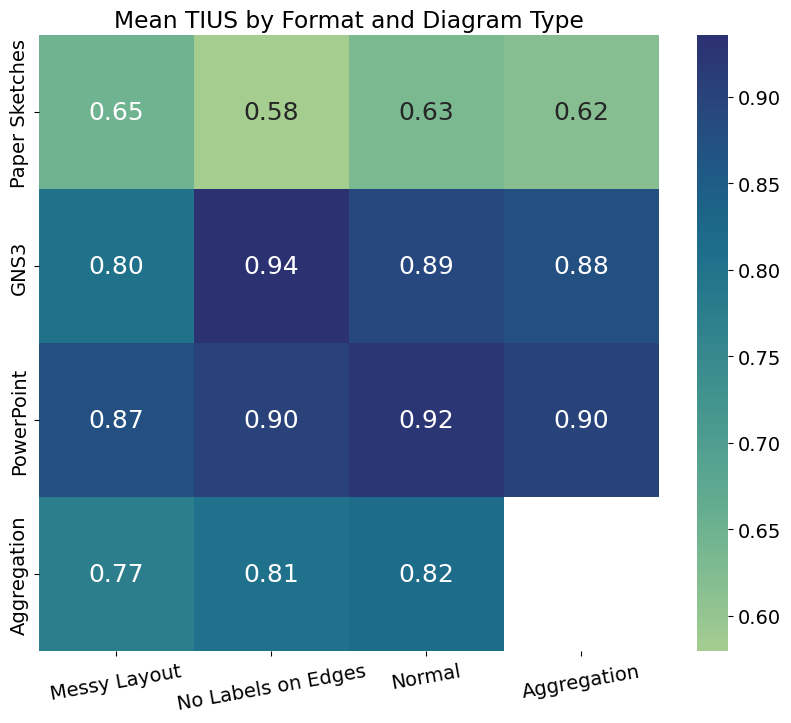

In [76]:
means = vision_scores.groupby(['Platform', 'Diagram_Type'])['Fixed TIUS'].mean().unstack()
sorted_means = means.loc[means.mean(axis=1).sort_values().index, means.mean(axis=0).sort_values().index]
sorted_means['Aggregation'] = vision_scores.groupby('Platform')['Fixed TIUS'].mean()
new_row = vision_scores.groupby('Diagram_Type')['Fixed TIUS'].mean()
sorted_means = pd.concat([sorted_means, pd.DataFrame([new_row], index=['Aggregation'])])
sorted_means.rename(columns={'No_Labels_On_Edges':'No Labels on Edges','Messy_Layout':'Messy Layout'},inplace=True)
sorted_means.index = sorted_means.index.where(sorted_means.index != 'Paper_Sketches', 'Paper Sketches')
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_means, annot=True, cmap='crest', fmt=".2f",annot_kws={"size": 18})
plt.title('Mean TIUS by Format and Diagram Type')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=10)
plt.show()

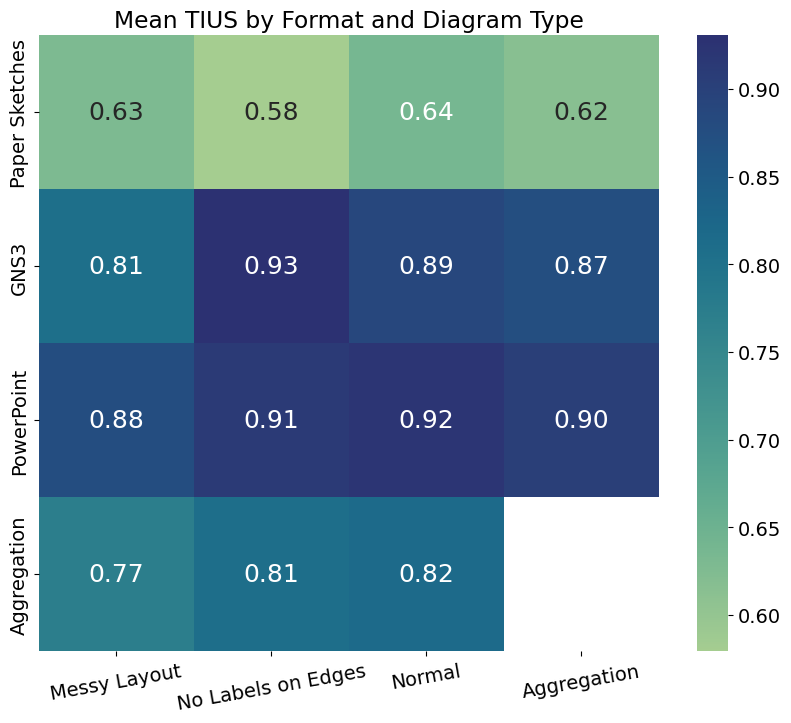

In [80]:
means = iv.groupby(['Platform', 'Diagram_Type'])['Fixed TIUS'].mean().unstack()
sorted_means = means.loc[means.mean(axis=1).sort_values().index, means.mean(axis=0).sort_values().index]
sorted_means['Aggregation'] = iv.groupby('Platform')['Fixed TIUS'].mean()
new_row = iv.groupby('Diagram_Type')['Fixed TIUS'].mean()
sorted_means = pd.concat([sorted_means, pd.DataFrame([new_row], index=['Aggregation'])])
sorted_means.rename(columns={'No_Labels_On_Edges':'No Labels on Edges','Messy_Layout':'Messy Layout'},inplace=True)
sorted_means.index = sorted_means.index.where(sorted_means.index != 'Paper_Sketches', 'Paper Sketches')
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_means, annot=True, cmap='crest', fmt=".2f",annot_kws={"size": 18})
plt.title('Mean TIUS by Format and Diagram Type')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=10)
plt.show()

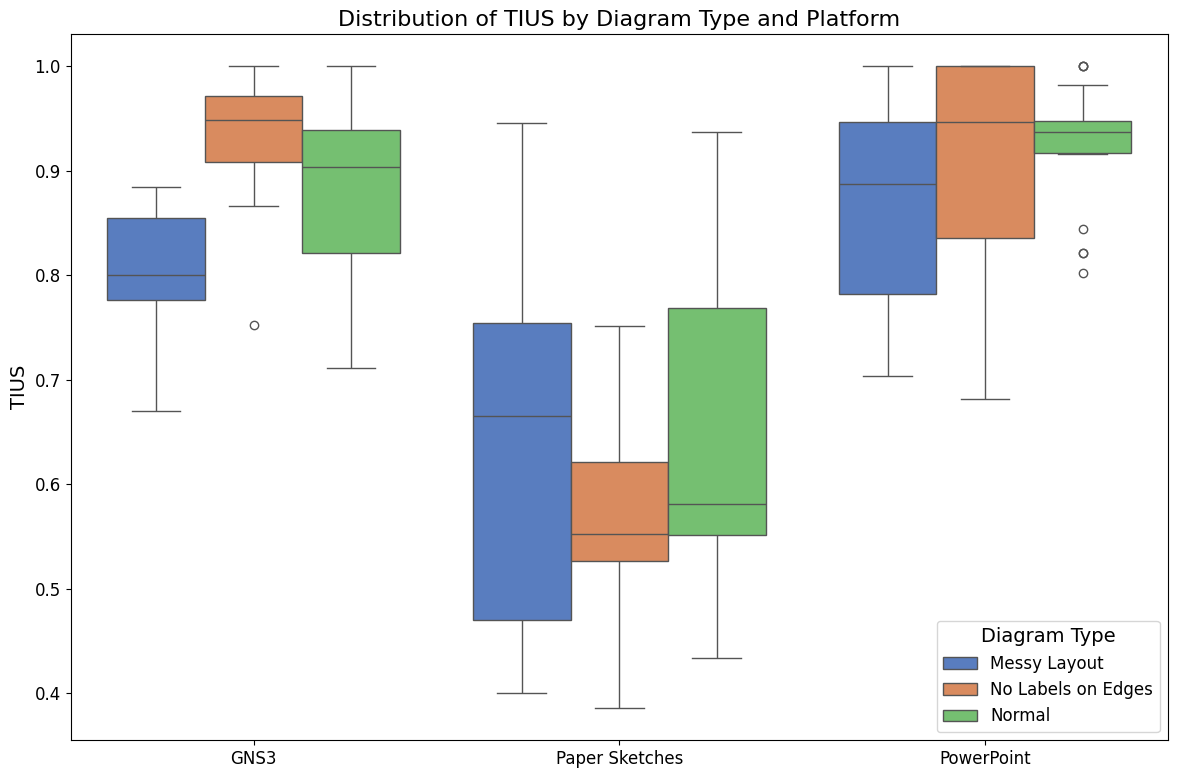

In [81]:
# Group the data by 'Platform' and 'Diagram_Type' and calculate mean scores.
means = vision_scores.groupby(['Platform', 'Diagram_Type'])['Fixed TIUS'].mean().reset_index()

# Create a boxplot.
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=vision_scores,
    x='Platform',
    y='Fixed TIUS',
    hue='Diagram_Type',
    palette='muted'
)

# Customize plot aesthetics.
plt.title('Distribution of TIUS by Diagram Type and Platform', fontsize=16)
plt.xlabel('', fontsize=14)
plt.ylabel('TIUS', fontsize=14)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Diagram Type', fontsize=12, title_fontsize=14, loc='lower right')
plt.xticks(rotation=0)
# Show the plot.
plt.tight_layout()
plt.show()

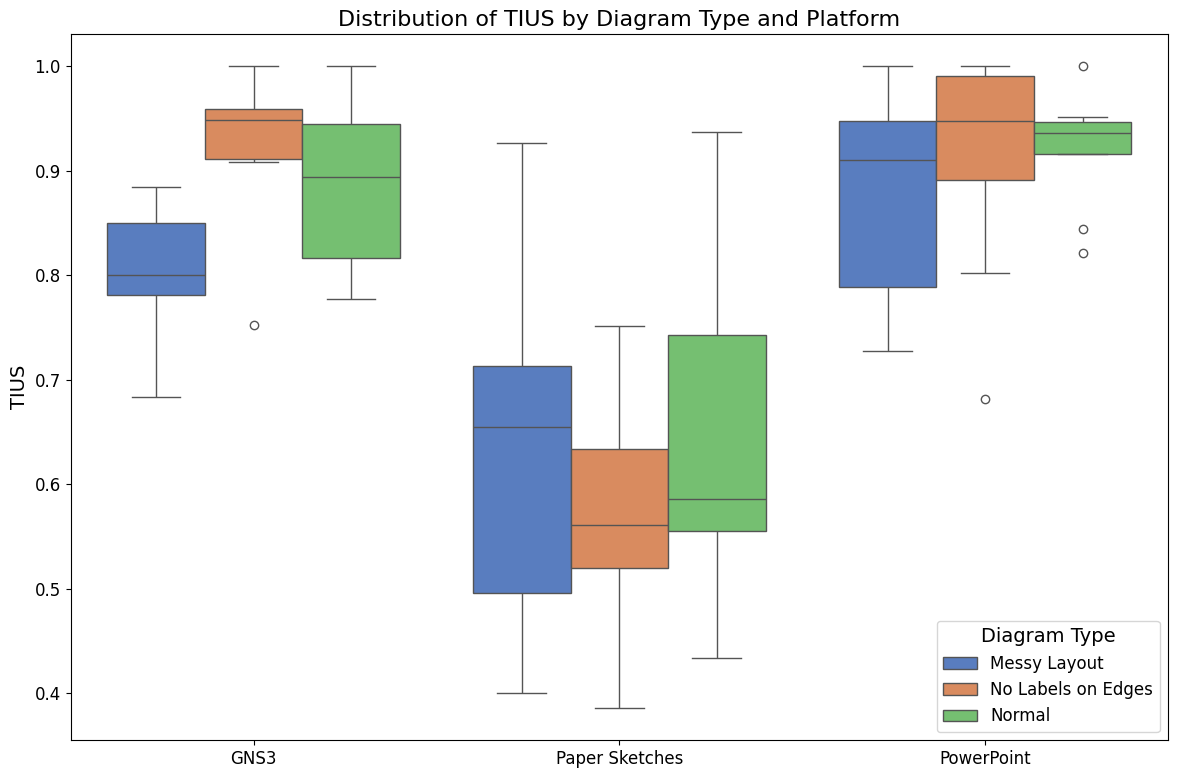

In [85]:
# Group the data by 'Platform' and 'Diagram_Type' and calculate mean scores.
means = iv.groupby(['Platform', 'Diagram_Type'])['Fixed TIUS'].mean().reset_index()

# Create a boxplot.
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=iv,
    x='Platform',
    y='Fixed TIUS',
    hue='Diagram_Type',
    palette='muted'
)

# Customize plot aesthetics.
plt.title('Distribution of TIUS by Diagram Type and Platform', fontsize=16)
plt.xlabel('', fontsize=14)
plt.ylabel('TIUS', fontsize=14)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Diagram Type', fontsize=12, title_fontsize=14, loc='lower right')
plt.xticks(rotation=0)
# Show the plot.
plt.tight_layout()
plt.show()

##RQ1 Statistical Tests

Levene's Variance Equality test for all groups alltogether

In [14]:
# Perform Levene's test
# Group data by 'Platform' and 'Diagram_Type'
groups = iv.groupby(['Platform', 'Diagram_Type'])['TIUS']

# Extract data for each group
data = [group.values for _, group in groups]

# Perform Levene's test
statistic, p_value = levene(*data)

print(f"Levene's Test Statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Variances are significantly different.")
else:
    print("Variances are not significantly different.")

Levene's Test Statistic: 1.3372085204242554
P-value: 0.23726015876620438
Variances are not significantly different.


Pairwise Leene's test

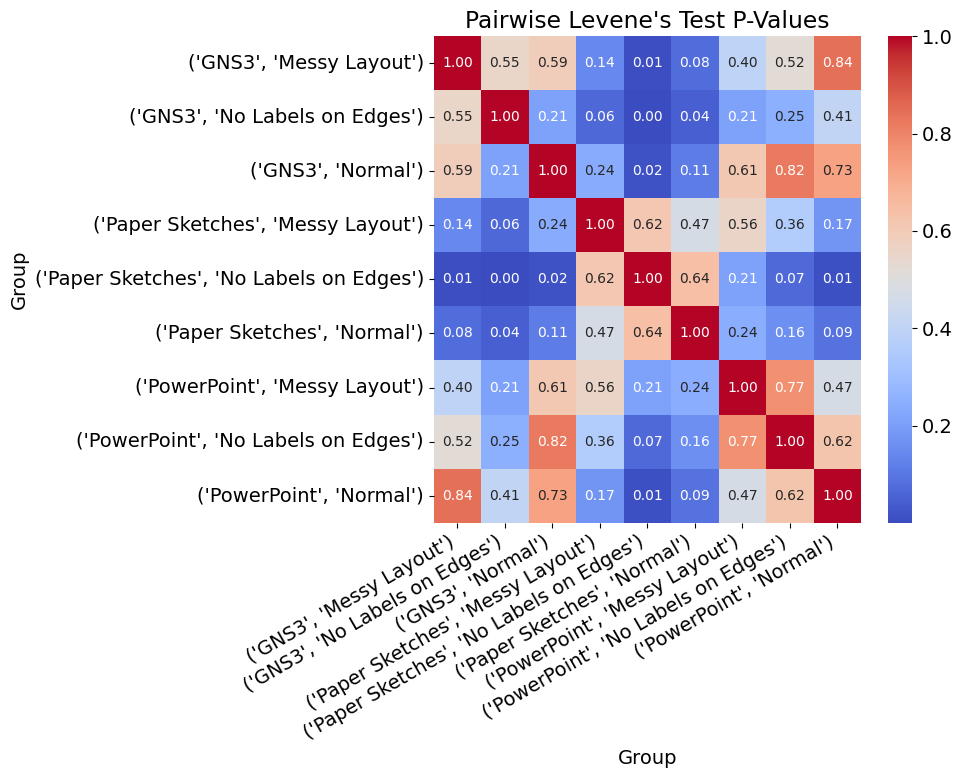

In [32]:
plt.rcParams['font.size'] = 14
groups = iv_all.groupby(['Platform', 'Diagram_Type'])['TIUS']

# Create a pivot table to store p-values
combinations = list(groups.groups.keys())
n = len(combinations)
p_values = np.zeros((n, n))

# Perform pairwise Levene's test and store the p-values
for i in range(n):
    for j in range(i, n):  # Only calculate upper triangle
        group1_name = combinations[i]
        group2_name = combinations[j]
        group1_data = iv_all[(iv_all['Platform'] == group1_name[0]) & (iv_all['Diagram_Type'] == group1_name[1])]['TIUS']
        group2_data = iv_all[(iv_all['Platform'] == group2_name[0]) & (iv_all['Diagram_Type'] == group2_name[1])]['TIUS']

        if i != j:
            _, p_value = levene(group1_data, group2_data)
        else:
            p_value = 1  # Variance is identical with itself

        p_values[i, j] = p_values[j, i] = p_value

# Create a DataFrame for the heatmap
p_values_df = pd.DataFrame(p_values, index=combinations, columns=combinations)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_values_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, xticklabels=True, yticklabels=True,annot_kws={"size": 10})
plt.title("Pairwise Levene's Test P-Values")
plt.xlabel("Group")
plt.ylabel("Group")
plt.xticks(rotation=30, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Kruskal-Wallis Test - compare means across one random variable**

Format:

In [17]:
# Perform Kruskal-Wallis test
groups = iv.groupby('Platform')['TIUS']
statistic, p_value = kruskal(*[group.values for _, group in groups])

print(f"Kruskal-Wallis Test Statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant difference in means across different Formats.")
else:
    print("There is no statistically significant difference in means across different Formats.")

Kruskal-Wallis Test Statistic: 19.238843469645996
P-value: 6.642601840238861e-05
There is a statistically significant difference in means across different Formats.


In [18]:
groups = iv.groupby('Diagram_Type')['TIUS']
statistic, p_value = kruskal(*[group.values for _, group in groups])

print(f"Kruskal-Wallis Test Statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant difference in means across different diagram variants.")
else:
    print("There is no statistically significant difference in means across different diagram variants.")

Kruskal-Wallis Test Statistic: 12.01519417755492
P-value: 0.0024599922270528785
There is a statistically significant difference in means across different diagram variants.


In [20]:
# Make sure the independent variables are categorical
iv['Platform'] = iv['Platform'].astype('category')
iv['Diagram_Type'] = iv['Diagram_Type'].astype('category')

# Reshape data to get all levels of 'Platform' and 'Diagram_Type'
# Here, I'm assuming you want to compare within these groups.

# Group by both 'Platform' and 'Diagram_Type' and get the dependent variable ('Fixed TIUS') for each combination
grouped = iv.groupby(['Platform', 'Diagram_Type'])['TIUS'].apply(list)

# Prepare data for Friedman test (each group will be one list of samples)
data = [group for group in grouped]

# Perform the Friedman test
stat, p_value = friedmanchisquare(*data)

print("Friedman test statistic:", stat)
print("P-value:", p_value)


Friedman test statistic: 32.27447698744774
P-value: 8.31653208880229e-05


<ipython-input-20-c59bb3e0bc0c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iv['Platform'] = iv['Platform'].astype('category')
<ipython-input-20-c59bb3e0bc0c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iv['Diagram_Type'] = iv['Diagram_Type'].astype('category')
<ipython-input-20-c59bb3e0bc0c>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future def

In [33]:
def calculate_information_gain(data, target_variable, feature):
    # Calculate entropy of the target variable
    target_entropy = entropy(data[target_variable].value_counts(normalize=True))

    # Calculate conditional entropy of target variable given the feature
    conditional_entropy = 0
    for value in data[feature].unique():
        subset = data[data[feature] == value]
        conditional_entropy += (len(subset) / len(data)) * entropy(subset[target_variable].value_counts(normalize=True))

    # Calculate information gain
    information_gain = target_entropy - conditional_entropy
    return information_gain

# Assuming 'vision_scores' DataFrame is already loaded
# Replace 'Fixed TIUS' with the actual column name if different
target_variable = 'TIUS'
features = ['Phase1_Temp', 'Platform', 'Scenario', 'Diagram_Type', 'Type']

for feature in features:
  try:
    information_gain = calculate_information_gain(iv_all, target_variable, feature)
    print(f"Information Gain of {feature} on {target_variable}: {information_gain}")
  except KeyError:
    print(f"Feature '{feature}' not found in the DataFrame. Skipping.")

Feature 'Phase1_Temp' not found in the DataFrame. Skipping.
Information Gain of Platform on TIUS: 1.046588608366731
Information Gain of Scenario on TIUS: 2.2813679540508858
Information Gain of Diagram_Type on TIUS: 1.0832090179890015
Information Gain of Type on TIUS: 0.6719300416167857


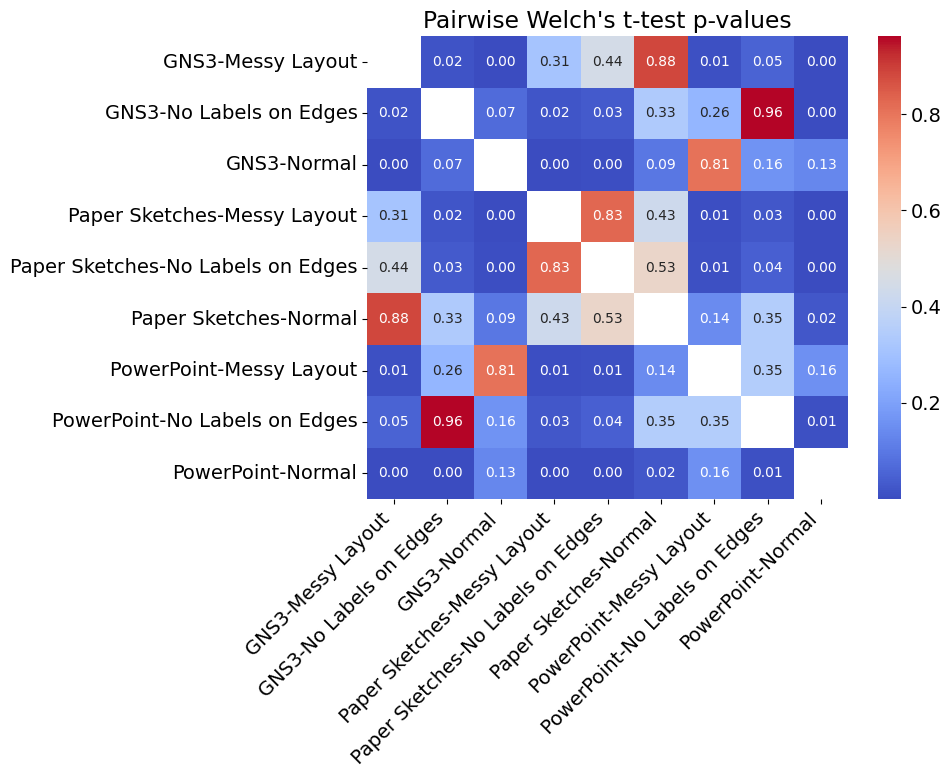

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

# Group data by 'Platform' and 'Diagram_Type'
groups = iv_all.groupby(['Platform', 'Diagram_Type'])['TIUS']

# Create a list of all unique group combinations
combinations = list(groups.groups.keys())
num_combinations = len(combinations)

# Perform pairwise Welch's t-tests
results = {}
p_values = np.full((num_combinations, num_combinations), np.nan)  # Matrix to store p-values

for i in range(num_combinations):
    for j in range(i + 1, num_combinations):
        group1_name = combinations[i]
        group2_name = combinations[j]

        group1_data = iv_all[
            (iv_all['Platform'] == group1_name[0]) &
            (iv_all['Diagram_Type'] == group1_name[1])
        ]['TIUS']

        group2_data = iv_all[
            (iv_all['Platform'] == group2_name[0]) &
            (iv_all['Diagram_Type'] == group2_name[1])
        ]['TIUS']

        t_stat, p_val = ttest_ind(group1_data, group2_data, equal_var=False)  # Welch's t-test
        results[(group1_name, group2_name)] = (t_stat, p_val)
        p_values[i, j] = p_val
        p_values[j, i] = p_val  # Symmetric matrix

# Convert the combinations to readable labels for the heatmap
labels = [f"{platform}-{diagram_type}" for platform, diagram_type in combinations]

# Create a DataFrame for the heatmap
p_values_df = pd.DataFrame(p_values, index=labels, columns=labels)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_values_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
            xticklabels=labels, yticklabels=labels,annot_kws={"size": 10})
plt.title("Pairwise Welch's t-test p-values")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Research Question 2
How well can GeNet assist with network topology update intents vs. configuration update intents?

In [35]:
plt.rcParams['font.size'] = 20

<ipython-input-13-d7b0e27670e4>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Score', data = iv_all, palette='muted')


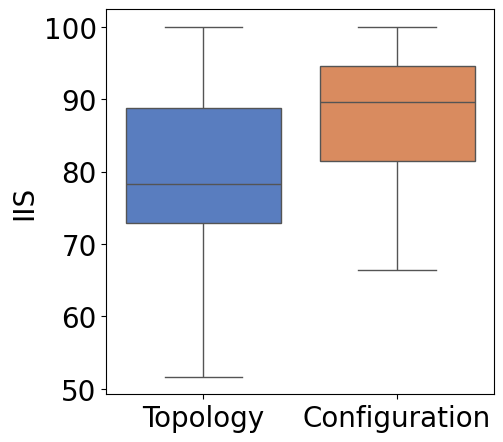

In [13]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='Type', y='Score', data = iv_all, palette='muted')
# sns.boxplot(x='Type', y='Score', data=data, palette='muted')
# plt.title('Box Plot of Score by Type')
plt.xlabel('')
plt.ylabel('IIS')
plt.show()

In [38]:
iv_all.groupby('Type')['Score'].mean()

,Score
Type,
Configuration,88.150000
Topology,80.052778


In [39]:
groups = iv_all.groupby('Type')['Score'].apply(list)

# Performing Levene's test
statistic, p_value = levene(*groups)

# Printing the results
print(f"Levene's variance equality test statistic: {statistic}")
print(f"Levene's test p-value: {p_value}")

# Determining significance and conclusion
alpha = 0.05  # Significance level
if p_value < alpha:
    print(f"The test is significant (p < {alpha}). Variances are not equal among the groups.")
else:
    print(f"The test is not significant (p >= {alpha}). Variances are equal among the groups.")

Levene's variance equality test statistic: 7.093333238847667
Levene's test p-value: 0.00920022242754849
The test is significant (p < 0.05). Variances are not equal among the groups.


In [40]:
# Grouping the data
groups = iv_all.groupby('Type')['Score'].apply(list)

# Performing Welch's t-test
group1, group2 = groups.iloc[0], groups.iloc[1]  # Assuming two groups for the t-test
statistic, p_value = ttest_ind(group1, group2, equal_var=False)

# Printing the results
print(f"Welch's t-test statistic: {statistic}")
print(f"Welch's t-test p-value: {p_value}")

# Determining significance and conclusion
alpha = 0.05  # Significance level
if p_value < alpha:
    print(f"The test is significant (p < {alpha}). The means of the two groups are significantly different.")
else:
    print(f"The test is not significant (p >= {alpha}). The means of the two groups are not significantly different.")


Welch's t-test statistic: 3.32631636613021
Welch's t-test p-value: 0.0013538498793885308
The test is significant (p < 0.05). The means of the two groups are significantly different.


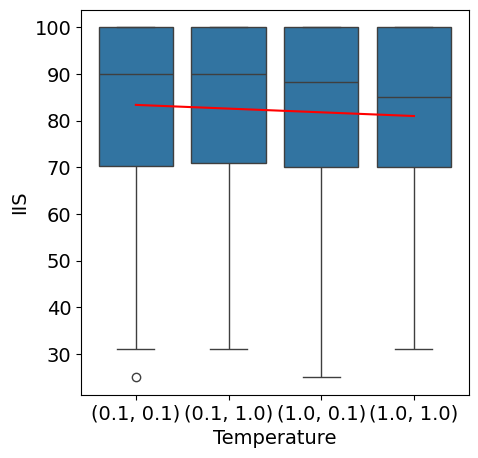

In [237]:
def plots_temps(df):
  plt.figure(figsize=(5, 5))
  sns.boxplot(x='Temp', y='weighted_score', data=df)
  means = df.groupby('Temp')['Score'].mean()
  x = range(0, len(means))
  slope, intercept = np.polyfit(x, means, 1)
  plt.plot(x, slope * x + intercept, color='r', linestyle='-')
  plt.xlabel('Temperature')
  plt.ylabel('IIS')
  plt.show()
plots_temps(data_four_one)

In [150]:
groups = data_four_one.groupby('Temp')['Score'].apply(list)

# Performing Levene's test
statistic, p_value = levene(*groups)

# Printing the results
print(f"Levene's variance equality test statistic: {statistic}")
print(f"Levene's test p-value: {p_value}")

# Determining significance and conclusion
alpha = 0.05  # Significance level
if p_value < alpha:
    print(f"The test is significant (p < {alpha}). Variances are not equal among the groups.")
else:
    print(f"The test is not significant (p >= {alpha}). Variances are equal among the groups.")

Levene's variance equality test statistic: 0.5618482317882331
Levene's test p-value: 0.6405135181878859
The test is not significant (p >= 0.05). Variances are equal among the groups.


In [1]:
# Grouping the data
groups = data_four_one.groupby('Temp')['Score'].apply(list)

# Performing Welch's ANOVA
anova_result = anova_oneway(groups, use_var='unequal', welch_correction=True)

# Printing the results
print(f"Welch's ANOVA F-statistic: {anova_result.statistic}")
print(f"Welch's ANOVA p-value: {anova_result.pvalue}")

# Determining significance and conclusion
alpha = 0.05  # Significance level
if anova_result.pvalue < alpha:
    print(f"The test is significant (p < {alpha}). There is a significant difference in means among the groups.")
else:
    print(f"The test is not significant (p >= {alpha}). There is no significant difference in means among the groups.")


NameError: name 'data_four_one' is not defined

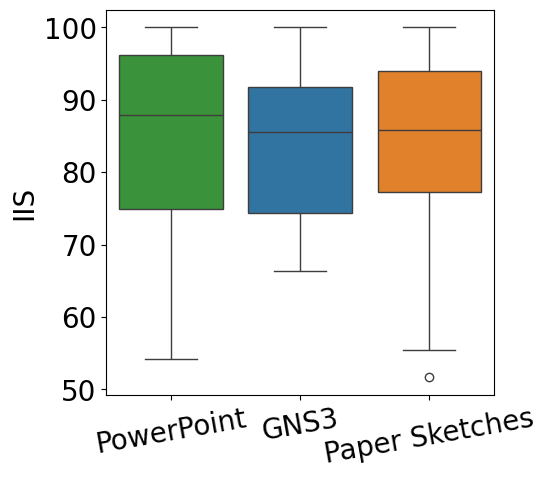

In [42]:
desired_order = ['PowerPoint','GNS3', 'Paper Sketches']  # Replace with your specific order
plt.figure(figsize=(5, 5))
sns.boxplot(x='Platform', y='Score', data = iv_all, hue='Platform',order = desired_order)
# plt.title("Topology Understanding Score vs Temperature Values")
plt.xlabel('')
plt.ylabel('IIS')
plt.xticks(rotation=10)
plt.show()


In [44]:
from itertools import combinations

In [45]:
# Grouping the data
groups = iv_all.groupby('Platform')['Score'].apply(list)

# Performing pairwise Welch's t-tests
print("Performing pairwise Welch's t-tests:")

# Initialize a list to store results
pairwise_results = []
alpha = 0.05  # Significance level

for (group1_name, group1_data), (group2_name, group2_data) in combinations(groups.items(), 2):
    # Welch's t-test with unequal variances
    stat, p = ttest_ind(group1_data, group2_data, equal_var=False)

    result = {
        'Group 1': group1_name,
        'Group 2': group2_name,
        'Statistic': stat,
        'p-value': p,
        'Conclusion': 'Significant' if p < alpha else 'Not Significant'
    }
    pairwise_results.append(result)

# Convert results into a DataFrame for better visualization
pairwise_results_df = pd.DataFrame(pairwise_results)
print(pairwise_results_df)


Performing pairwise Welch's t-tests:
          Group 1         Group 2  Statistic   p-value       Conclusion
0            GNS3  Paper Sketches   0.243750  0.808319  Not Significant
1            GNS3      PowerPoint  -0.224147  0.823463  Not Significant
2  Paper Sketches      PowerPoint  -0.426608  0.671244  Not Significant


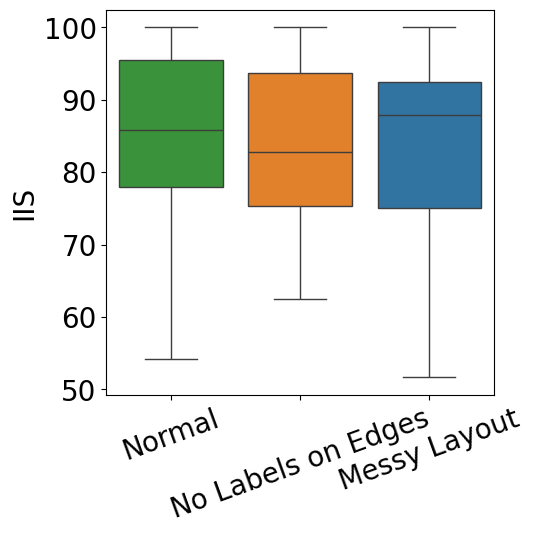

In [47]:
desired_order = ['Normal','No Labels on Edges', 'Messy Layout']
plt.figure(figsize=(5, 5))
sns.boxplot(x='Diagram_Type', y='Score', data=iv_all, hue='Diagram_Type', order = desired_order)
# plt.title("Topology Understanding Score vs Temperature Values")
plt.xlabel('')
plt.ylabel('IIS')
plt.xticks(rotation=20)
plt.show()

In [48]:
# Grouping the data
groups = iv_all.groupby('Diagram_Type')['Score'].apply(list)

# Performing pairwise Welch's t-tests
print("Performing pairwise Welch's t-tests:")

# Initialize a list to store results
pairwise_results = []
alpha = 0.05  # Significance level

for (group1_name, group1_data), (group2_name, group2_data) in combinations(groups.items(), 2):
    # Welch's t-test with unequal variances
    stat, p = ttest_ind(group1_data, group2_data, equal_var=False)

    result = {
        'Group 1': group1_name,
        'Group 2': group2_name,
        'Statistic': stat,
        'p-value': p,
        'Conclusion': 'Significant' if p < alpha else 'Not Significant'
    }
    pairwise_results.append(result)

# Convert results into a DataFrame for better visualization
pairwise_results_df = pd.DataFrame(pairwise_results)
print(pairwise_results_df)


Performing pairwise Welch's t-tests:
              Group 1             Group 2  Statistic   p-value  \
0        Messy Layout  No Labels on Edges   0.245055  0.807282   
1        Messy Layout              Normal  -0.139472  0.889564   
2  No Labels on Edges              Normal  -0.376108  0.708239   

        Conclusion  
0  Not Significant  
1  Not Significant  
2  Not Significant  


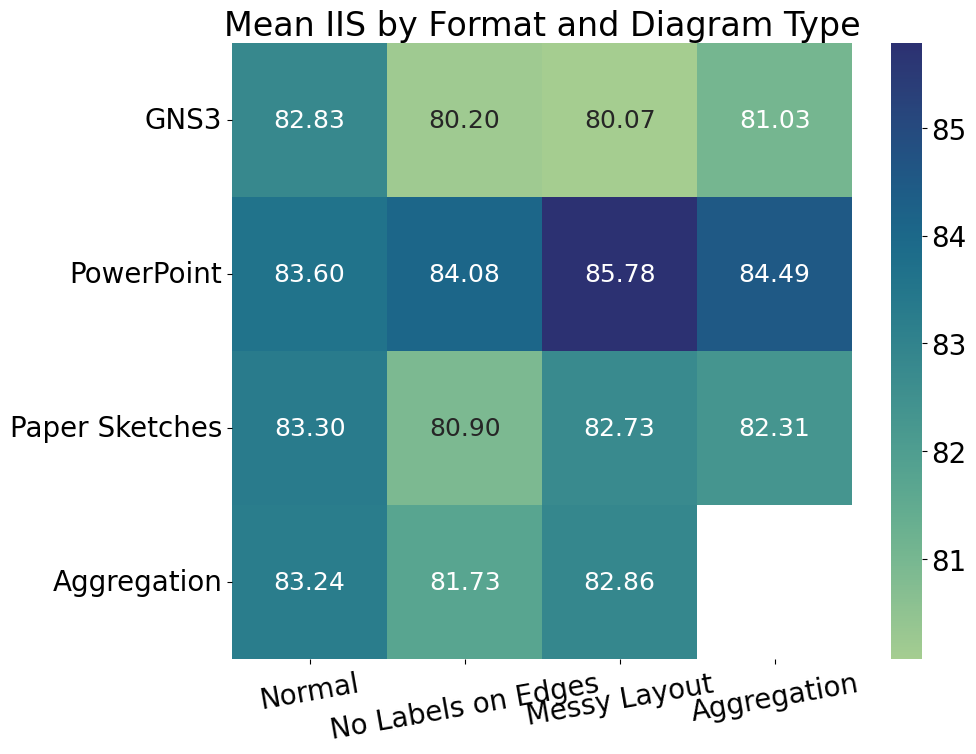

In [70]:
def plot_heatmap(df,goal):
  means = df.groupby(['Platform', 'Diagram_Type'])[goal].mean().unstack()
  row_order = ['GNS3','PowerPoint','Paper Sketches','Aggregation']  # Update with your actual row names
  column_order = ['Normal', 'No Labels on Edges','Messy Layout', 'Aggregation']  # Update with your actual column names
  means['Aggregation'] = df.groupby('Platform')[goal].mean()
  new_row = df.groupby('Diagram_Type')[goal].mean()
  means = pd.concat([means, pd.DataFrame([new_row], index=['Aggregation'])])
  means = means.reindex(index=row_order, columns=column_order)
  plt.figure(figsize=(10, 8))
  sns.heatmap(means, annot=True, cmap='crest', fmt=".2f",annot_kws={"size": 18})
  plt.title('Mean IIS by Format and Diagram Type')
  plt.xlabel('')
  plt.ylabel('')
  plt.xticks(rotation=10)
  plt.show()
plot_heatmap(iv,'Score')

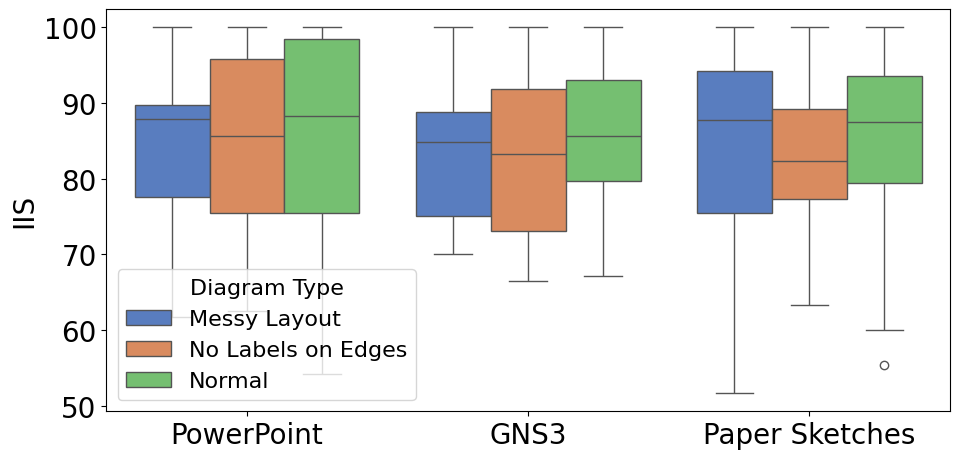

In [49]:
# Group the data by 'Platform' and 'Diagram_Type' and calculate mean scores.
desired_order = ['PowerPoint','GNS3', 'Paper Sketches']  # Replace with your specific order
def plot_boxplots(df,goal):
  means = df.groupby(['Platform', 'Diagram_Type'])[goal].mean().reset_index()

  # Create a boxplot.
  plt.figure(figsize=(10, 5))
  sns.boxplot(
      data=df,
      x='Platform',
      y='Score',
      hue='Diagram_Type',
      palette='muted',
      order = desired_order
  )

  # Customize plot aesthetics.
  # plt.title('Distribution of IIS by Diagram Type and Platform')
  plt.xlabel('')
  plt.ylabel('IIS')
  # plt.xticks(rotation=15)
  plt.yticks()

  plt.legend(title='Diagram Type', loc='lower left', title_fontsize=16, fontsize=16)
  # plt.legend.get_frame().set_alpha(0.5)
  plt.xticks(rotation=0)
  # Show the plot.
  plt.tight_layout()
  plt.show()
plot_boxplots(iv_all,'Score')

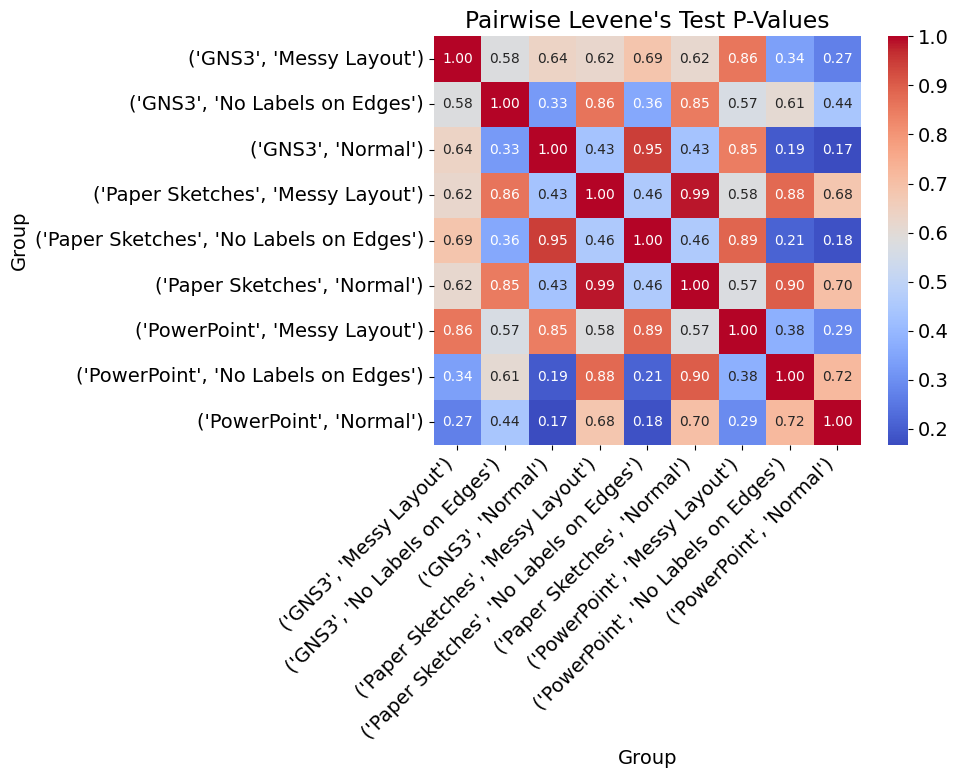

In [50]:
plt.rcParams['font.size'] = 14

groups = iv_all.groupby(['Platform', 'Diagram_Type'])['Score']
# Create a pivot table to store p-values
combinations = list(groups.groups.keys())
n = len(combinations)
p_values = np.zeros((n, n))

# Perform pairwise Levene's test and store the p-values
for i in range(n):
    for j in range(i, n):  # Only calculate upper triangle
        group1_name = combinations[i]
        group2_name = combinations[j]
        group1_data = iv_all[(iv_all['Platform'] == group1_name[0]) & (iv_all['Diagram_Type'] == group1_name[1])]['Score']
        group2_data = iv_all[(iv_all['Platform'] == group2_name[0]) & (iv_all['Diagram_Type'] == group2_name[1])]['Score']

        if i != j:
            _, p_value = levene(group1_data, group2_data)
        else:
            p_value = 1  # Variance is identical with itself

        p_values[i, j] = p_values[j, i] = p_value

# Create a DataFrame for the heatmap
p_values_df = pd.DataFrame(p_values, index=combinations, columns=combinations)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_values_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, xticklabels=True, yticklabels=True,annot_kws={"size": 10})
plt.title("Pairwise Levene's Test P-Values")
plt.xlabel("Group")
plt.ylabel("Group")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

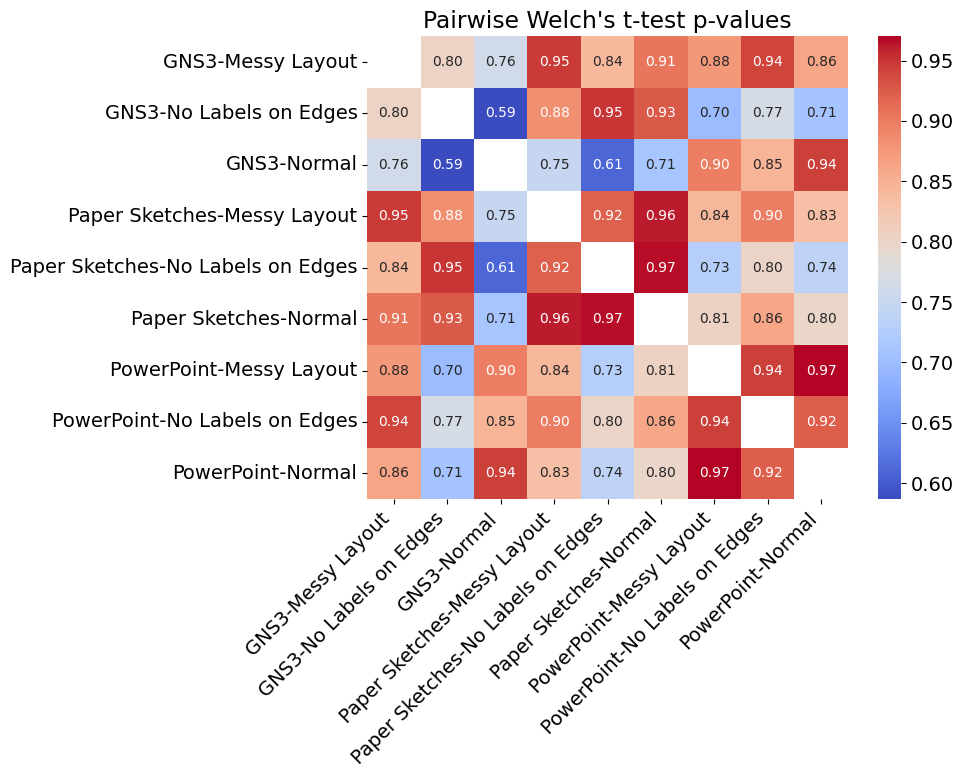

In [52]:
# Group data by 'Platform' and 'Diagram_Type'
groups = iv_all.groupby(['Platform', 'Diagram_Type'])['Score']

# Create a list of all unique group combinations
combinations = list(groups.groups.keys())
num_combinations = len(combinations)

# Perform pairwise Welch's t-tests
results = {}
p_values = np.full((num_combinations, num_combinations), np.nan)  # Matrix to store p-values

for i in range(num_combinations):
    for j in range(i + 1, num_combinations):
        group1_name = combinations[i]
        group2_name = combinations[j]

        group1_data = iv_all[
            (iv_all['Platform'] == group1_name[0]) &
            (iv_all['Diagram_Type'] == group1_name[1])
        ]['Score']

        group2_data = iv_all[
            (iv_all['Platform'] == group2_name[0]) &
            (iv_all['Diagram_Type'] == group2_name[1])
        ]['Score']

        t_stat, p_val = ttest_ind(group1_data, group2_data, equal_var=False)  # Welch's t-test
        results[(group1_name, group2_name)] = (t_stat, p_val)
        p_values[i, j] = p_val
        p_values[j, i] = p_val  # Symmetric matrix

# Convert the combinations to readable labels for the heatmap
labels = [f"{platform}-{diagram_type}" for platform, diagram_type in combinations]

# Create a DataFrame for the heatmap
p_values_df = pd.DataFrame(p_values, index=labels, columns=labels)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_values_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
            xticklabels=labels, yticklabels=labels,annot_kws={"size": 10})
plt.title("Pairwise Welch's t-test p-values")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [53]:
target_variable = 'Score'
features = ['Temp', 'Platform', 'Scenario', 'Diagram_Type', 'Type','TIUS']

for feature in features:
  try:
    information_gain = calculate_information_gain(iv_all, target_variable, feature)
    print(f"Information Gain of {feature} on {target_variable}: {information_gain}")
  except KeyError:
    print(f"Feature '{feature}' not found in the DataFrame. Skipping.")

Information Gain of Temp on Score: 0.0
Information Gain of Platform on Score: 0.7526572587844029
Information Gain of Scenario on Score: 2.024379281165685
Information Gain of Diagram_Type on Score: 0.7680605294635123
Information Gain of Type on Score: 0.5043545860890348
Information Gain of TIUS on Score: 3.8063613556952482


## Research Question 3
To what extent does the quality of GeNet’s solutions depend on its topology image understanding?

In [80]:
plt.rcParams['font.size'] = 20

Configuration: Pearson correlation = 0.07, p-value = 0.67
Configuration: Spearman correlation = 0.12, p-value = 0.42
Topology: Pearson correlation = -0.05, p-value = 0.76
Topology: Spearman correlation = 0.01, p-value = 0.95


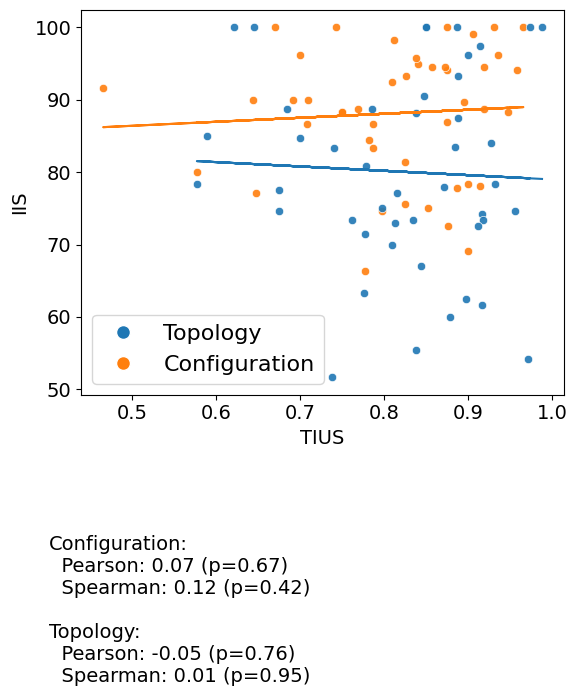

In [54]:
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import numpy as np

def scatter(df,goal):
  # Define specific colors for 'Topology' and 'Configuration'
  type_colors = {
      'Topology': plt.get_cmap('tab10')(0),     # Blue
      'Configuration': plt.get_cmap('tab10')(1)  # Orange
  }

  plt.figure(figsize=(6, 6))

  # Initialize a string to collect correlation information
  correlation_info = ""

  # Scatter plot and regression for each 'Type'
  for type_value, group_data in df.groupby('Type'):
      x_group = group_data['TIUS']
      y_group = group_data[goal]

      # Scatter plot with specific color
      plt.scatter(x_group, y_group, alpha=0.9, edgecolors='w', linewidth=0.5,
                  label=f"{type_value}", color=type_colors[type_value])

      # Linear regression for the current 'Type'
      slope, intercept = np.polyfit(x_group, y_group, 1)
      regression_line = slope * x_group + intercept
      plt.plot(x_group, regression_line, color=type_colors[type_value],
               label=f"{type_value} Regression Line")

      # Calculate Pearson and Spearman correlations
      pearson_corr, p_value = pearsonr(x_group, y_group)
      spearman_corr, p_value_spearman = spearmanr(x_group, y_group)

      # Append correlation info for display below the plot
      correlation_info += (
          f"{type_value}:\n"
          f"  Pearson: {pearson_corr:.2f} (p={p_value:.2g})\n"
          f"  Spearman: {spearman_corr:.2f} (p={p_value_spearman:.2g})\n\n"
      )

      print(f"{type_value}: Pearson correlation = {pearson_corr:.2f}, p-value = {p_value:.2g}")
      print(f"{type_value}: Spearman correlation = {spearman_corr:.2f}, p-value = {p_value_spearman:.2g}")

  # Adding labels
  plt.xlabel('TIUS')
  plt.ylabel('IIS')

  # Custom legend
  legend_elements = [
      plt.Line2D([0], [0], marker='o', color='w', label=type_value,
                 markerfacecolor=type_colors[type_value], markersize=10)
      for type_value in type_colors.keys()
  ]

  # Adding the legend to the plot
  plt.legend(handles=legend_elements, loc='lower left',fontsize = 16)

  # Adding the correlation info as text below the plot
  plt.figtext(0.1, -0.15, correlation_info.strip(), wrap=True, horizontalalignment='left')

  # Adjust plot layout to make space for the text
  plt.tight_layout(rect=[0, 0.2, 1, 1])  # Leave space at the bottom for text

  # Adding a grid
  # plt.grid(True)

  # Display the plot
  plt.show()

scatter(iv_all,'Score')

In [89]:
# Function to remove outliers using the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # print(lower_bound)
    # print(upper_bound)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [116]:
i = data_four_one[data_four_one['Temp'] == '(0.1, 0.1)']
ii = data_four_one[data_four_one['Temp'] == '(0.1, 1.0)']
iii = data_four_one[data_four_one['Temp'] == '(1.0, 0.1)']
iv = data_four_one[data_four_one['Temp'] == '(1.0, 1.0)']
df_topo = data_four_one[data_four_one['Type'] == 'Topology']
df_config = data_four_one[data_four_one['Type'] == 'Configuration']
target_temps = ['(0.1, 0.1)', '(1.0, 1.0)']

# Filter the DataFrame
aligned_temps = data_four_one[data_four_one['Temp'].isin(target_temps)]

In [211]:
filtered_df = data_four_one[(data_four_one['Platform'] == 'Paper Sketches')]# &(data_four_one['Diagram_Type'] == 'Messy Layout')
len(filtered_df)

120

In [99]:
def z_score_normalize(column):
    return (column - column.mean()) / column.std()
iv['Norm TIUS'] = z_score_normalize(iv['TIUS'])
# iv['Norm WIIS'] = z_score_normalize(iv['weighted_score'])
iv['Norm IIS'] = z_score_normalize(iv['Score'])

<ipython-input-99-adbb45dce910>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iv['Norm TIUS'] = z_score_normalize(iv['TIUS'])
<ipython-input-99-adbb45dce910>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iv['Norm IIS'] = z_score_normalize(iv['Score'])


In [100]:
# data_four_one['Rescaled TIUS'] = data_four_one['Fixed TIUS'] * 100
# data_four_one = data_four_one[['Type','Scenario','Temp','Score','Rescaled TIUS']]
# melted = data_four_one.melt(id_vars=['Scenario','Temp','Type'], var_name='Metric', value_name='Value')
# data_four_one = data_four_one[['Type','Scenario','Temp','Norm IIS','Norm TIUS']]
iv = iv[['Type','Scenario','Temp','Norm IIS','Norm TIUS']]
melted = iv.melt(id_vars=['Scenario','Temp','Type'], var_name='Metric', value_name='Value')
melted

,Scenario,Temp,Type,Metric,Value
0,Adding Communication Servers,"(1.0, 1.0)",Topology,Norm IIS,-0.946978
1,Adding DMZ,"(1.0, 1.0)",Topology,Norm IIS,-1.322432
2,Adding DRA,"(1.0, 1.0)",Topology,Norm IIS,-2.323642
3,Adding Local PCs,"(1.0, 1.0)",Topology,Norm IIS,0.179383
4,Internet Connectivity,"(1.0, 1.0)",Topology,Norm IIS,1.305745
...,...,...,...,...,...
175,Role Based CLI Access,"(1.0, 1.0)",Configuration,Norm TIUS,-0.322943
176,Time Based Access List,"(1.0, 1.0)",Configuration,Norm TIUS,1.069420
177,Transparent IOS Firewall,"(1.0, 1.0)",Configuration,Norm TIUS,0.669792
178,Basic Zone Based Firewall,"(1.0, 1.0)",Configuration,Norm TIUS,1.020031


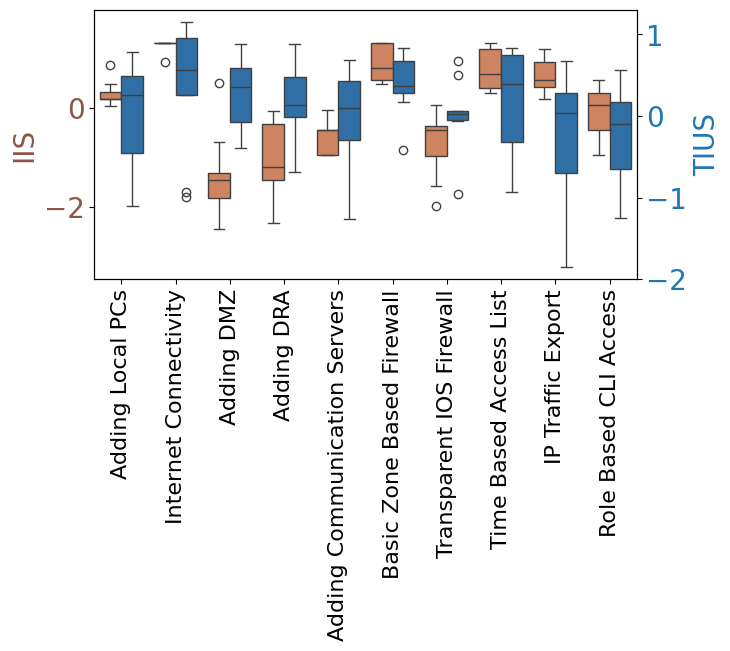

In [107]:
custom_order = ['Adding Local PCs', 'Internet Connectivity', 'Adding DMZ', 'Adding DRA', 'Adding Communication Servers', 'Basic Zone Based Firewall', 'Transparent IOS Firewall', 'Time Based Access List', 'IP Traffic Export', 'Role Based CLI Access']
# custom_palette = {'Score': '#e07c4f', 'Rescaled TIUS': '#1C70B9'}
custom_palette = {'Norm IIS': '#e07c4f', 'Norm TIUS': '#1C70B9'}
fig, ax1 = plt.subplots(figsize=(7, 3.5))

color = 'tab:brown'
ax1.set_xlabel("")
ax1.set_ylabel('IIS', color=color)
sns.boxplot(x='Scenario', y='Value', hue='Metric', data=melted, palette=custom_palette, order=custom_order)
# ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
# ax1.set_ylim(bottom=-2, top= 1.5)
plt.xlabel('')
plt.xticks(rotation=90,fontsize=16)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('TIUS', color=color)  # we already handled the x-label with ax1
# sns.boxplot(x='Scenario', y='Score', hue='Type', data=total_data_clean, palette='muted')
#ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(bottom=-2, top= 1.3)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend_.set_visible(False)
plt.show()

# Correlation between questionnaire and WIIS

In [65]:
plt.rcParams.update({'font.size': 20})

In [8]:
 means = iv.groupby('Scenario')['Score'].mean()
 means

,Score
Scenario,
Adding Communication Servers,75.037037
Adding DMZ,63.981481
Adding DRA,68.148148
Adding Local PCs,86.333333
Basic Zone Based Firewall,94.481481
IP Traffic Export,91.111111
Internet Connectivity,99.444444
Role Based CLI Access,81.481481
Time Based Access List,92.814815


IIS

In [55]:
# from scipy.stats import pearsonr, spearmanr
means = iv_all.groupby('Scenario')['Score'].mean()

scneario_complexity_ranks = [4,8,10,3,9,7,6,2,1,5] #sorted by the means' order
# likert_scores = [2.444,3.166668,4.8333,2.333,3.555,3,3,2.222,1.8888,2.9444] - no correlation at all
# Pearson correlation
pearson_corr, pearson_p_value = pearsonr(means, scneario_complexity_ranks)
print(f"Pearson Correlation: {pearson_corr}, p-value: {pearson_p_value}")

# Spearman correlation
spearman_corr, spearman_p_value = spearmanr(means, scneario_complexity_ranks)
print(f"Spearman Correlation: {spearman_corr}, p-value: {spearman_p_value}")


Pearson Correlation: -0.2124367045677239, p-value: 0.5557047922799658
Spearman Correlation: -0.13939393939393938, p-value: 0.7009318849100584


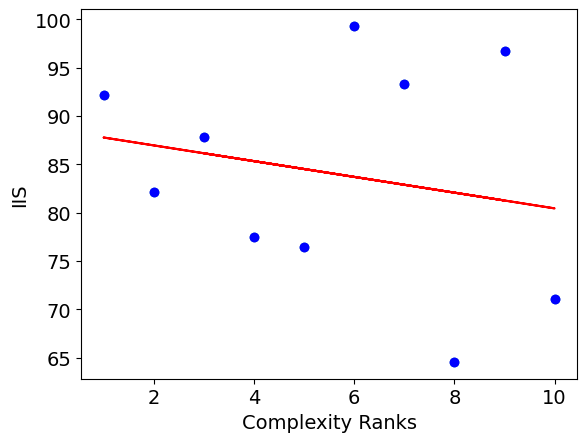

In [56]:
means = iv_all.groupby('Scenario')['Score'].mean()

plt.scatter(scneario_complexity_ranks, means)

# Calculate regression line
slope, intercept, r_value, p_value, std_err = linregress(scneario_complexity_ranks, means)

# Generate predicted values
regression_line = [slope * x + intercept for x in scneario_complexity_ranks]

# Plot scatter plot
plt.scatter(scneario_complexity_ranks, means, color='blue', label='Data points')

# Plot regression line
plt.plot(scneario_complexity_ranks, regression_line, color='red', label=f'Regression Line (r={r_value:.2f})')

# Add labels, legend, and title
plt.xlabel('Complexity Ranks')
plt.ylabel('IIS')
plt.title('')
# plt.legend()
plt.show()


In [67]:
# Define your custom mapping of scenarios to bins
scenario_to_bin = {
    'Adding DRA': 'Hard',
    'Basic Zone Based Firewall': 'Hard',
    'Adding DMZ': 'Hard',
    'IP Traffic Export': 'Hard',
    'Internet Connectivity': 'Hard',
    'Transparent IOS Firewall': 'Easy', #?
    'Adding Communication Servers': 'Easy',
    'Adding Local PCs': 'Easy',
    'Role Based CLI Access': 'Easy',
    'Time Based Access List': 'Easy'
}

# Create a new column in the DataFrame based on the mapping
iv_all['Complexity'] = iv_all['Scenario'].map(scenario_to_bin)

<ipython-input-68-c3be894e15d3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Complexity', y='Score', data = iv_all, palette=palette)


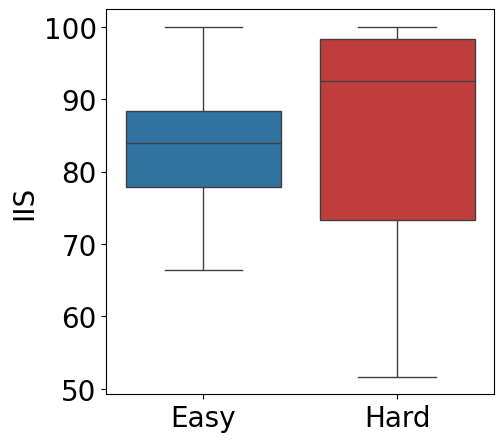

,Score
Complexity,
Easy,83.222222
Hard,84.980556


In [68]:
plt.figure(figsize=(5, 5))
palette = ['#1f77b4', '#d62728']
sns.boxplot(x='Complexity', y='Score', data = iv_all, palette=palette)
# sns.boxplot(x='Type', y='Score', data=data, palette='muted')
# plt.title('Box Plot of Score by Type')
plt.xlabel('')
plt.ylabel('IIS')
plt.show()
iv_all.groupby('Complexity')['Score'].mean()

In [61]:
# Grouping the data
groups = iv_all.groupby('Complexity')['Score'].apply(list)

# Performing Welch's t-test
group1, group2 = groups.iloc[0], groups.iloc[1]  # Assuming two groups for the t-test
statistic, p_value = ttest_ind(group1, group2, equal_var=False)

# Printing the results
print(f"Welch's t-test statistic: {statistic}")
print(f"Welch's t-test p-value: {p_value}")

# Determining significance and conclusion
alpha = 0.05  # Significance level
if p_value < alpha:
    print(f"The test is significant (p < {alpha}). The means of the two groups are significantly different.")
else:
    print(f"The test is not significant (p >= {alpha}). The means of the two groups are not significantly different.")

Welch's t-test statistic: -0.682586902106807
Welch's t-test p-value: 0.4972821452679471
The test is not significant (p >= 0.05). The means of the two groups are not significantly different.


In [62]:
groups = iv_all.groupby('Complexity')['Score'].apply(list)

# Performing Levene's test
statistic, p_value = levene(*groups)

# Printing the results
print(f"Levene's variance equality test statistic: {statistic}")
print(f"Levene's test p-value: {p_value}")

# Determining significance and conclusion
alpha = 0.05  # Significance level
if p_value < alpha:
    print(f"The test is significant (p < {alpha}). Variances are not equal among the groups.")
else:
    print(f"The test is not significant (p >= {alpha}). Variances are equal among the groups.")

Levene's variance equality test statistic: 12.162206667069716
Levene's test p-value: 0.0007634219857161896
The test is significant (p < 0.05). Variances are not equal among the groups.


3 bins

In [85]:
plt.rcParams.update({'font.size': 20})

In [86]:
# Define your custom mapping of scenarios to bins
scenario_to_bin = {
    'Adding DRA': 'Hard',
    'Basic Zone Based Firewall': 'Hard',
    'Adding DMZ': 'Medium',
    'IP Traffic Export': 'Medium',
    'Internet Connectivity': 'Medium',
    'Transparent IOS Firewall': 'Medium', #?
    'Adding Communication Servers': 'Easy',
    'Adding Local PCs': 'Easy',
    'Role Based CLI Access': 'Easy',
    'Time Based Access List': 'Easy'
}

# Create a new column in the DataFrame based on the mapping
iv_all['Complexity'] = iv_all['Scenario'].map(scenario_to_bin)

<ipython-input-91-ef0a4db902ef>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Complexity', y='Score', data = iv_all, palette=palette)


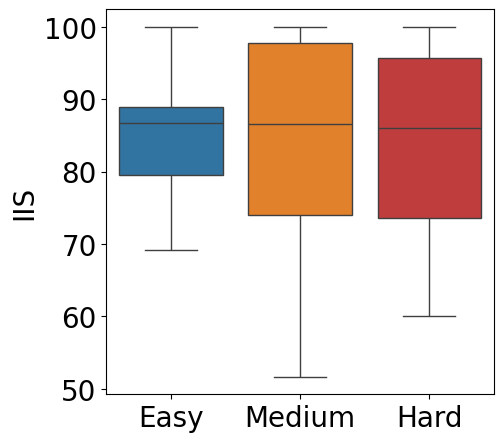

,Score
Complexity,
Easy,84.909722
Hard,83.851852
Medium,83.417824


In [91]:
plt.figure(figsize=(5, 5))
palette = ['#1f77b4', '#ff7f0e', '#d62728']#, '#d62728', '#9467bd']
sns.boxplot(x='Complexity', y='Score', data = iv_all, palette=palette)
# sns.boxplot(x='Type', y='Score', data=data, palette='muted')
# plt.title('Box Plot of Score by Type')
plt.xlabel('')
plt.ylabel('IIS')
plt.show()
iv_all.groupby('Complexity')['Score'].mean()

In [69]:
from scipy.stats import levene, kruskal

# Grouping the data
groups = iv_all.groupby('Complexity')['Score'].apply(list)

# Performing Levene's test
levene_statistic, levene_p_value = levene(*groups)

# Printing Levene's test results
print(f"Levene's variance equality test statistic: {levene_statistic}")
print(f"Levene's test p-value: {levene_p_value}")

# Determining significance and conclusion for Levene's test
alpha = 0.05  # Significance level
if levene_p_value < alpha:
    print(f"The test is significant (p < {alpha}). Variances are not equal among the groups.")
else:
    print(f"The test is not significant (p >= {alpha}). Variances are equal among the groups.")

# Performing Kruskal-Wallis H-test
kruskal_statistic, kruskal_p_value = kruskal(*groups)

# Printing Kruskal-Wallis results
print(f"\nKruskal-Wallis H-test statistic: {kruskal_statistic}")
print(f"Kruskal-Wallis H-test p-value: {kruskal_p_value}")

# Determining significance and conclusion for Kruskal-Wallis test
if kruskal_p_value < alpha:
    print(f"The Kruskal-Wallis test is significant (p < {alpha}). At least one group distribution is significantly different.")
else:
    print(f"The Kruskal-Wallis test is not significant (p >= {alpha}). Group distributions are not significantly different.")


Levene's variance equality test statistic: 12.162206667069716
Levene's test p-value: 0.0007634219857161896
The test is significant (p < 0.05). Variances are not equal among the groups.

Kruskal-Wallis H-test statistic: 2.5338354786381823
Kruskal-Wallis H-test p-value: 0.11142906851681621
The Kruskal-Wallis test is not significant (p >= 0.05). Group distributions are not significantly different.


TIUS

In [70]:
# from scipy.stats import pearsonr, spearmanr
means = iv_all.groupby('Scenario')['TIUS'].mean()

scneario_complexity_ranks = [4,8,10,3,9,7,6,2,1,5] #sorted by the means' order
# likert_scores = [2.444,3.166668,4.8333,2.333,3.555,3,3,2.222,1.8888,2.9444] - no correlation at all
# Pearson correlation
pearson_corr, pearson_p_value = pearsonr(means, scneario_complexity_ranks)
print(f"Pearson Correlation: {pearson_corr}, p-value: {pearson_p_value}")

# Spearman correlation
spearman_corr, spearman_p_value = spearmanr(means, scneario_complexity_ranks)
print(f"Spearman Correlation: {spearman_corr}, p-value: {spearman_p_value}")


Pearson Correlation: 0.4074010075278409, p-value: 0.24257789499206145
Spearman Correlation: 0.2727272727272727, p-value: 0.44583834154275137


Text(0.5, 1.0, '')

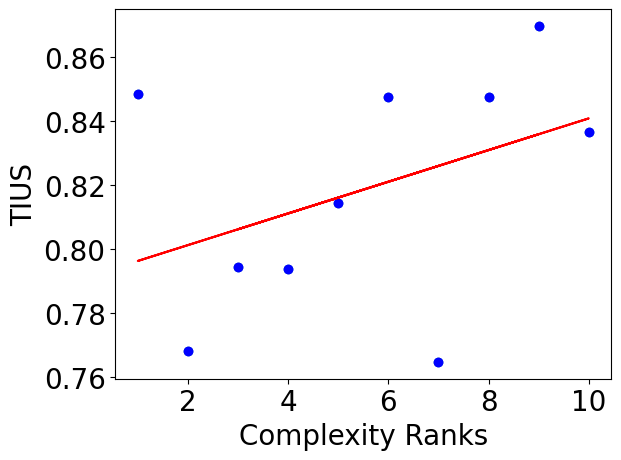

In [71]:
means = iv_all.groupby('Scenario')['TIUS'].mean()
plt.scatter(scneario_complexity_ranks, means)

# Calculate regression line
slope, intercept, r_value, p_value, std_err = linregress(scneario_complexity_ranks, means)

# Generate predicted values
regression_line = [slope * x + intercept for x in scneario_complexity_ranks]

# Plot scatter plot
plt.scatter(scneario_complexity_ranks, means, color='blue', label='Data points')

# Plot regression line
plt.plot(scneario_complexity_ranks, regression_line, color='red', label=f'Regression Line (r={r_value:.2f})')

# Add labels, legend, and title
plt.xlabel('Complexity Ranks')
plt.ylabel('TIUS')
plt.title('')
# plt.legend()

In [82]:
# Define your custom mapping of scenarios to bins
scenario_to_bin = {
    'Adding DRA': 'Hard',
    'Basic Zone Based Firewall': 'Hard',
    'Adding DMZ': 'Hard',
    'IP Traffic Export': 'Hard',
    'Internet Connectivity': 'Hard',
    'Transparent IOS Firewall': 'Easy', #?
    'Adding Communication Servers': 'Easy',
    'Adding Local PCs': 'Easy',
    'Role Based CLI Access': 'Easy',
    'Time Based Access List': 'Easy'
}

# Create a new column in the DataFrame based on the mapping
iv_all['Complexity'] = iv_all['Scenario'].map(scenario_to_bin)

<ipython-input-83-437aaf636e0d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Complexity', y='TIUS', data=iv_all, palette=palette)


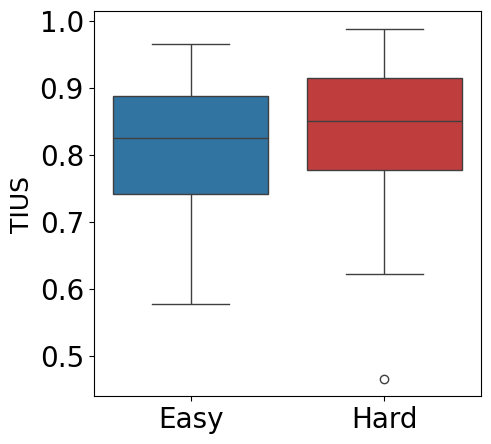

,TIUS
Complexity,
Easy,0.803831
Hard,0.833326


In [83]:
plt.figure(figsize=(5, 5))
palette = ['#1f77b4', '#d62728']
# plt.rcParams.update({'font.size': 14})
sns.boxplot(x='Complexity', y='TIUS', data=iv_all, palette=palette)
# sns.boxplot(x='Type', y='Score', data=data, palette='muted')
# plt.title('Topology Extractor Module Score by Test Case Type')
plt.xlabel('')
plt.ylabel('TIUS',fontsize=18)
plt.show()
iv_all.groupby('Complexity')['TIUS'].mean()

In [76]:
groups = iv_all.groupby('Complexity')['TIUS'].apply(list)

# Performing Levene's test
statistic, p_value = levene(*groups)

# Printing the results
print(f"Levene's variance equality test statistic: {statistic}")
print(f"Levene's test p-value: {p_value}")

# Determining significance and conclusion
alpha = 0.05  # Significance level
if p_value < alpha:
    print(f"The test is significant (p < {alpha}). Variances are not equal among the groups.")
else:
    print(f"The test is not significant (p >= {alpha}). Variances are equal among the groups.")

Levene's variance equality test statistic: 0.2071179095278217
Levene's test p-value: 0.650156624197245
The test is not significant (p >= 0.05). Variances are equal among the groups.


In [77]:
# Grouping the data
groups = iv_all.groupby('Complexity')['TIUS'].apply(list)

# Performing Welch's t-test
group1, group2 = groups.iloc[0], groups.iloc[1]  # Assuming two groups for the t-test
statistic, p_value = ttest_ind(group1, group2, equal_var=False)

# Printing the results
print(f"Welch's t-test statistic: {statistic}")
print(f"Welch's t-test p-value: {p_value}")

# Determining significance and conclusion
alpha = 0.05  # Significance level
if p_value < alpha:
    print(f"The test is significant (p < {alpha}). The means of the two groups are significantly different.")
else:
    print(f"The test is not significant (p >= {alpha}). The means of the two groups are not significantly different.")

Welch's t-test statistic: -1.3323214141803983
Welch's t-test p-value: 0.18619621987921636
The test is not significant (p >= 0.05). The means of the two groups are not significantly different.


In [78]:
# Define your custom mapping of scenarios to bins
scenario_to_bin = {
    'Adding DRA': 'Hard',
    'Basic Zone Based Firewall': 'Hard',
    'Adding DMZ': 'Medium',
    'IP Traffic Export': 'Medium',
    'Internet Connectivity': 'Medium',
    'Transparent IOS Firewall': 'Medium', #?
    'Adding Communication Servers': 'Easy',
    'Adding Local PCs': 'Easy',
    'Role Based CLI Access': 'Easy',
    'Time Based Access List': 'Easy'
}

# Create a new column in the DataFrame based on the mapping
iv_all['Complexity'] = iv_all['Scenario'].map(scenario_to_bin)

<ipython-input-80-43fed6e8932e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Complexity', y='TIUS', data = iv_all, palette=palette)


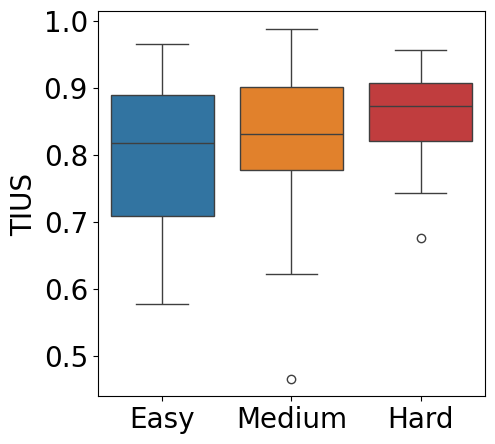

,TIUS
Complexity,
Easy,0.801157
Hard,0.853287
Medium,0.818645


In [80]:
plt.figure(figsize=(5, 5))
palette = ['#1f77b4', '#ff7f0e', '#d62728']#, '#d62728', '#9467bd']
sns.boxplot(x='Complexity', y='TIUS', data = iv_all, palette=palette)
# sns.boxplot(x='Type', y='Score', data=data, palette='muted')
# plt.title('Box Plot of Score by Type')
plt.xlabel('')
plt.ylabel('TIUS')
plt.show()
iv_all.groupby('Complexity')['TIUS'].mean()

In [84]:
from scipy.stats import levene, kruskal

# Grouping the data
groups = iv_all.groupby('Complexity')['TIUS'].apply(list)

# Performing Levene's test
levene_statistic, levene_p_value = levene(*groups)

# Printing Levene's test results
print(f"Levene's variance equality test statistic: {levene_statistic}")
print(f"Levene's test p-value: {levene_p_value}")

# Determining significance and conclusion for Levene's test
alpha = 0.05  # Significance level
if levene_p_value < alpha:
    print(f"The test is significant (p < {alpha}). Variances are not equal among the groups.")
else:
    print(f"The test is not significant (p >= {alpha}). Variances are equal among the groups.")

# Performing Kruskal-Wallis H-test
kruskal_statistic, kruskal_p_value = kruskal(*groups)

# Printing Kruskal-Wallis results
print(f"\nKruskal-Wallis H-test statistic: {kruskal_statistic}")
print(f"Kruskal-Wallis H-test p-value: {kruskal_p_value}")

# Determining significance and conclusion for Kruskal-Wallis test
if kruskal_p_value < alpha:
    print(f"The Kruskal-Wallis test is significant (p < {alpha}). At least one group distribution is significantly different.")
else:
    print(f"The Kruskal-Wallis test is not significant (p >= {alpha}). Group distributions are not significantly different.")


Levene's variance equality test statistic: 0.2071179095278217
Levene's test p-value: 0.650156624197245
The test is not significant (p >= 0.05). Variances are equal among the groups.

Kruskal-Wallis H-test statistic: 2.145307419389361
Kruskal-Wallis H-test p-value: 0.14300638818472178
The Kruskal-Wallis test is not significant (p >= 0.05). Group distributions are not significantly different.


#Anomaly Detection


In [119]:
# prompt: I want to view samples in which 'Score' is high and 'TIUS' is low - use quartiles

# Calculate quartiles for 'Score' and 'TIUS'
score_q1 = data_four_one['Score'].quantile(0.25)
score_q3 = data_four_one['Score'].quantile(0.75)
tius_q1 = data_four_one['TIUS'].quantile(0.25)
tius_q3 = data_four_one['TIUS'].quantile(0.75)

# Filter the DataFrame
high_score_low_tius = data_four_one[
    (data_four_one['Score'] >= score_q3) & (data_four_one['TIUS'] <= tius_q1)
]

# Display the filtered samples
high_score_low_tius

,Scenario,Run,Temp,Platform,Diagram_Type,Type,Score,TIUS
16,Internet Connectivity,1,"(0.1, 0.1)",GNS3,Messy Layout,Topology,100.0,0.629167
17,Internet Connectivity,1,"(0.1, 1.0)",GNS3,Messy Layout,Topology,100.0,0.629167
18,Internet Connectivity,1,"(1.0, 0.1)",GNS3,Messy Layout,Topology,100.0,0.654167
19,Internet Connectivity,1,"(1.0, 1.0)",GNS3,Messy Layout,Topology,100.0,0.654167
134,Adding Local PCs,1,"(1.0, 0.1)",Paper Sketches,Messy Layout,Topology,100.0,0.742045
136,Internet Connectivity,1,"(0.1, 0.1)",Paper Sketches,Messy Layout,Topology,100.0,0.627778
137,Internet Connectivity,1,"(0.1, 1.0)",Paper Sketches,Messy Layout,Topology,100.0,0.627778
138,Internet Connectivity,1,"(1.0, 0.1)",Paper Sketches,Messy Layout,Topology,100.0,0.677273
139,Internet Connectivity,1,"(1.0, 1.0)",Paper Sketches,Messy Layout,Topology,100.0,0.677273
159,IP Traffic Export,1,"(1.0, 1.0)",Paper Sketches,Messy Layout,Configuration,100.0,0.593358


In [37]:
df = pd.read_csv('/gdrive/MyDrive/AUTONET/Vision_Experiment_Results/phase1_result_parsed_to_json/phase1_Run1_results_parsed_to_json_dict_results.csv')
df['Scenario'] = df['Scenario'].str.replace('_', ' ')
df['Platform'] = df['Platform'].str.replace('_', ' ')
df['Diagram_Type'] = df['Diagram_Type'].str.replace('_', ' ')
df

,N1,N2,E1,E2,NPL,NPI,sim_E,sim_EPlabel,Metric_score,Scenario,Platform,Diagram_Type,Temp,Run,Time
0,13,13,12,23,0.923077,0.923077,8,0,0.652508,Adding Communication Servers,GNS3,Messy Layout,0.1,1,0.001094
1,13,13,12,12,0.923077,0.923077,9,0,0.793269,Adding Communication Servers,GNS3,Messy Layout,1.0,1,0.000968
2,20,20,19,21,0.950000,0.900000,12,21,0.785000,Adding DMZ,GNS3,Messy Layout,0.1,1,0.002931
3,20,20,19,22,1.000000,0.950000,11,19,0.765682,Adding DMZ,GNS3,Messy Layout,1.0,1,0.003305
4,20,20,19,21,1.000000,0.950000,8,0,0.680833,Adding DRA,GNS3,Messy Layout,0.1,1,0.003016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,23,23,22,21,1.000000,1.000000,19,27,0.913636,Transparent IOS Firewall,PowerPoint,Normal,1.0,1,0.007941
176,20,20,19,17,1.000000,0.950000,17,25,0.926447,Basic Zone Based Firewall,PowerPoint,Normal,0.1,1,0.006036
177,20,20,19,17,1.000000,0.950000,17,25,0.926447,Basic Zone Based Firewall,PowerPoint,Normal,1.0,1,0.003168
178,20,21,19,19,0.952381,0.809524,17,28,0.903509,IP Traffic Export,PowerPoint,Normal,0.1,1,0.005592


In [43]:
high_score_low_tius['Temp'] = high_score_low_tius['Temp'].apply(lambda x: float(x[1:4]))

<ipython-input-43-649e6a2cf986>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_score_low_tius['Temp'] = high_score_low_tius['Temp'].apply(lambda x: float(x[1:4]))


#Last chence for TIUS VS IIS including runs 4 and 5 let's go!!!

In [8]:
runs4_5 = pd.read_csv('./Vision_Experiment_Results/phase1_result_parsed_to_json/phase1_Runs_4_5.csv')
runs4_5 = runs4_5[['Scenario','Platform','Diagram_Type','Temp','Average_4_5']]
runs4_5.rename(columns={'Average_4_5': 'TIUS'}, inplace=True)
runs4_5['Scenario'] = runs4_5['Scenario'].str.replace('_', ' ')
runs4_5['Diagram_Type'] = runs4_5['Diagram_Type'].replace('Messy_Layout', 'Messy Layout')
runs4_5['Platform'] = runs4_5['Platform'].replace('Paper_Sketches', 'Paper Sketches')
runs4_5['Diagram_Type'] = runs4_5['Diagram_Type'].replace('No_Labels_On_Edges', 'No Labels on Edges')
configuration_scenarios = ['Role Based CLI Access', 'Time Based Access List', 'IP Traffic Export','Transparent IOS Firewall','Basic Zone Based Firewall'] # Replace with your actual scenario names
topology_scenarios = ['Internet Connectivity', 'Adding DMZ', 'Adding DRA', 'Adding Local PCs', 'Adding Communication Servers'] # Replace with your actual scenario names
runs4_5['Type'] = 'Unknown'
# Assign 'Configuration' to the corresponding scenarios
runs4_5.loc[runs4_5['Scenario'].isin(configuration_scenarios), 'Type'] = 'Configuration'
# Assign 'Topology' to the corresponding scenarios
runs4_5.loc[runs4_5['Scenario'].isin(topology_scenarios), 'Type'] = 'Topology'
runs4_5

,Scenario,Platform,Diagram_Type,Temp,TIUS,Type
0,Adding Communication Servers,GNS3,Messy Layout,1,0.797436,Topology
1,Adding DMZ,GNS3,Messy Layout,1,0.795197,Topology
2,Adding DRA,GNS3,Messy Layout,1,0.764803,Topology
3,Adding Local PCs,GNS3,Messy Layout,1,0.708021,Topology
4,Internet Connectivity,GNS3,Messy Layout,1,0.646667,Topology
...,...,...,...,...,...,...
85,Role Based CLI Access,PowerPoint,Normal,1,0.787273,Configuration
86,Time Based Access List,PowerPoint,Normal,1,1.000000,Configuration
87,Transparent IOS Firewall,PowerPoint,Normal,1,0.884091,Configuration
88,Basic Zone Based Firewall,PowerPoint,Normal,1,0.943553,Configuration


In [9]:
phase4_avg45 = pd.read_csv('/gdrive/MyDrive/AUTONET/Vision_Experiment_Results/Corrected_verifier_LLM_Evaluator_with_descriptions/Phase4_run_4_5.csv')
phase4_avg45 = phase4_avg45[['Scenario','Platform','Diagram_Type','Averag_4_5']]
phase4_avg45.rename(columns={'Averag_4_5':'Score'},inplace=True)
phase4_avg45['Scenario'] = phase4_avg45['Scenario'].str.replace('_', ' ')
phase4_avg45['Diagram_Type'] = phase4_avg45['Diagram_Type'].replace('Messy_Layout', 'Messy Layout')
phase4_avg45['Platform'] = phase4_avg45['Platform'].replace('Paper_Sketches', 'Paper Sketches')
phase4_avg45['Diagram_Type'] = phase4_avg45['Diagram_Type'].replace('No_Labels_On_Edges', 'No Labels on Edges')
configuration_scenarios = ['Role Based CLI Access', 'Time Based Access List', 'IP Traffic Export','Transparent IOS Firewall','Basic Zone Based Firewall'] # Replace with your actual scenario names
topology_scenarios = ['Internet Connectivity', 'Adding DMZ', 'Adding DRA', 'Adding Local PCs', 'Adding Communication Servers'] # Replace with your actual scenario names
phase4_avg45['Type'] = 'Unknown'
# Assign 'Configuration' to the corresponding scenarios
phase4_avg45.loc[phase4_avg45['Scenario'].isin(configuration_scenarios), 'Type'] = 'Configuration'
# Assign 'Topology' to the corresponding scenarios
phase4_avg45.loc[phase4_avg45['Scenario'].isin(topology_scenarios), 'Type'] = 'Topology'

#Join phase 1 and phase 4 results
runs4_5.rename(columns={'Temp':'Phase1_Temp'},inplace=True)
iv_4_5 = phase4_avg45.merge(runs4_5, on=['Scenario','Platform','Diagram_Type','Type'])

iv_4_5

,Scenario,Platform,Diagram_Type,Score,Type,Phase1_Temp,TIUS
0,Adding Communication Servers,GNS3,Messy Layout,70.0,Topology,1,0.797436
1,Adding DMZ,GNS3,Messy Layout,85.0,Topology,1,0.795197
2,Adding DRA,GNS3,Messy Layout,95.0,Topology,1,0.764803
3,Adding Local PCs,GNS3,Messy Layout,92.5,Topology,1,0.708021
4,Internet Connectivity,GNS3,Messy Layout,100.0,Topology,1,0.646667
...,...,...,...,...,...,...,...
85,Role Based CLI Access,PowerPoint,Normal,90.0,Configuration,1,0.787273
86,Time Based Access List,PowerPoint,Normal,100.0,Configuration,1,1.000000
87,Transparent IOS Firewall,PowerPoint,Normal,81.0,Configuration,1,0.884091
88,Basic Zone Based Firewall,PowerPoint,Normal,100.0,Configuration,1,0.943553


In [10]:
iv_all = iv_4_5.merge(iv, on=['Scenario','Platform','Diagram_Type','Type'])
iv_all['Score'] = (iv_all['Score_x'] + iv_all['Score_y'])/2
iv_all['TIUS'] = (iv_all['TIUS_x'] + iv_all['TIUS_y'])/2
iv_all = iv_all.drop(columns=['Score_x','Score_y','TIUS_x','TIUS_y','weighted_score','Phase1_Temp'])
# iv_all = iv_all[['Scenario','Platform','Diagram_Type',]]
iv_all

,Scenario,Platform,Diagram_Type,Type,Temp,Score,TIUS
0,Adding Communication Servers,GNS3,Messy Layout,Topology,"(1.0, 1.0)",70.000000,0.809241
1,Adding DMZ,GNS3,Messy Layout,Topology,"(1.0, 1.0)",75.000000,0.797296
2,Adding DRA,GNS3,Messy Layout,Topology,"(1.0, 1.0)",73.333333,0.761644
3,Adding Local PCs,GNS3,Messy Layout,Topology,"(1.0, 1.0)",88.750000,0.786144
4,Internet Connectivity,GNS3,Messy Layout,Topology,"(1.0, 1.0)",100.000000,0.645417
...,...,...,...,...,...,...,...
85,Role Based CLI Access,PowerPoint,Normal,Configuration,"(1.0, 1.0)",83.333333,0.787273
86,Time Based Access List,PowerPoint,Normal,Configuration,"(1.0, 1.0)",100.000000,0.965783
87,Transparent IOS Firewall,PowerPoint,Normal,Configuration,"(1.0, 1.0)",77.833333,0.887121
88,Basic Zone Based Firewall,PowerPoint,Normal,Configuration,"(1.0, 1.0)",96.166667,0.935000


Configuration: Pearson correlation = 0.07, p-value = 0.67
Configuration: Spearman correlation = 0.12, p-value = 0.42
Topology: Pearson correlation = -0.05, p-value = 0.76
Topology: Spearman correlation = 0.01, p-value = 0.95


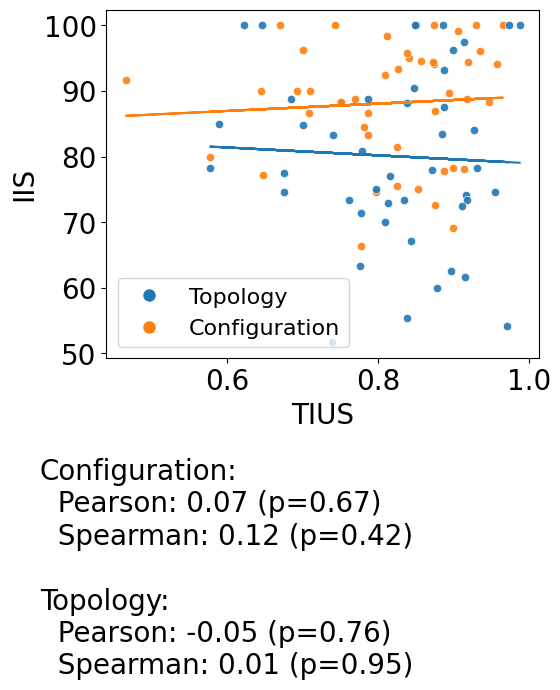

In [21]:
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import numpy as np

def scatter(df,goal):
  # Define specific colors for 'Topology' and 'Configuration'
  type_colors = {
      'Topology': plt.get_cmap('tab10')(0),     # Blue
      'Configuration': plt.get_cmap('tab10')(1)  # Orange
  }

  plt.figure(figsize=(6, 6))

  # Initialize a string to collect correlation information
  correlation_info = ""

  # Scatter plot and regression for each 'Type'
  for type_value, group_data in df.groupby('Type'):
      x_group = group_data['TIUS']
      y_group = group_data[goal]

      # Scatter plot with specific color
      plt.scatter(x_group, y_group, alpha=0.9, edgecolors='w', linewidth=0.5,
                  label=f"{type_value}", color=type_colors[type_value])

      # Linear regression for the current 'Type'
      slope, intercept = np.polyfit(x_group, y_group, 1)
      regression_line = slope * x_group + intercept
      plt.plot(x_group, regression_line, color=type_colors[type_value],
               label=f"{type_value} Regression Line")

      # Calculate Pearson and Spearman correlations
      pearson_corr, p_value = pearsonr(x_group, y_group)
      spearman_corr, p_value_spearman = spearmanr(x_group, y_group)

      # Append correlation info for display below the plot
      correlation_info += (
          f"{type_value}:\n"
          f"  Pearson: {pearson_corr:.2f} (p={p_value:.2g})\n"
          f"  Spearman: {spearman_corr:.2f} (p={p_value_spearman:.2g})\n\n"
      )

      print(f"{type_value}: Pearson correlation = {pearson_corr:.2f}, p-value = {p_value:.2g}")
      print(f"{type_value}: Spearman correlation = {spearman_corr:.2f}, p-value = {p_value_spearman:.2g}")

  # Adding labels
  plt.xlabel('TIUS')
  plt.ylabel('IIS')

  # Custom legend
  legend_elements = [
      plt.Line2D([0], [0], marker='o', color='w', label=type_value,
                 markerfacecolor=type_colors[type_value], markersize=10)
      for type_value in type_colors.keys()
  ]

  # Adding the legend to the plot
  plt.legend(handles=legend_elements, loc='lower left',fontsize = 16)

  # Adding the correlation info as text below the plot
  plt.figtext(0.1, -0.15, correlation_info.strip(), wrap=True, horizontalalignment='left')

  # Adjust plot layout to make space for the text
  plt.tight_layout(rect=[0, 0.2, 1, 1])  # Leave space at the bottom for text

  # Adding a grid
  # plt.grid(True)

  # Display the plot
  plt.show()

scatter(iv_all,'Score')